This script loads raw neuropixel spike times and prepares data for further analysis by performing the following steps:
1. Select which task entries to analyze
2. Load behavioral data and select good trials based on the reach time distributions.
3. Load neuropixel spike times
    - Bin spike times
    - Align data to the even of interest
    - Smooth timeseries with a Gaussian kernel
4. Saves preprocessed data
5. Plots basic neural data figures
    - Trial averaged firing rate
    - Raster plots
    - Raster plots organized by target direction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
import multiprocessing as mp
import time
import glob
from datetime import date

/home/aolab/miniconda3/envs/np_targeting/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [2]:
aopy.utils.get_memory_available_gb()
aopy.utils.release_memory_limit()

# Set Parameters

In [3]:
# Paths
subject = 'affi'
data_path_preproc = '/media/moor-data/preprocessed.new/'
data_path_raw = '/media/moor-data/raw/neuropixels/'
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
behavior_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/behavior"
ap_band_power_save_dir = f"/media/moor-data/postprocessed/{subject}/neuropixel_ap_band_power"
save_ap_band_power = True

# General data parameters
task_coords = 'yzx'
task_perturb = None
task_rotation = 0

# Task event code definitions
task_codes = aopy.data.bmi3d.load_bmi3d_task_codes()
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239
target_idx_to_use = np.array([1,2,3,4,5,6,7,8])
# # Select which event to align to
# # align_event = 'TARGET ONSET'
# # align_event = 'GO CUE'
# align_event = 'MOVEMENT ONSET'
# # align_event = 'ENTER TARGET'
# END_TRIAL_CODE = REWARD


# Trial selection parameters
trial_filter = lambda t: CENTER_TARGET_OFF in t
success_rate_window = 19
reach_time_std_thresh = 3

# Neuropixel data parameters
implant_name = ['NP_Insert72', 'NP_Insert137']
start_date = '2023-07-13'
if subject == 'beignet':
    end_date = '2024-02-05' # for beignet
else:
    start_date = '2023-10-29'
    end_date = date.today()
elec_config = 'bottom'
spike_bin_width_mc = 0.01 #[s]
smooth_width = 150
smooth_nstd = 3
min_trials_to_target = 28 # If None, code will automatically update with as many trials as possible while keeping the same number of trials to each target and on each recording
# min_trials_to_target = 10
filter_trials_by_eye = False

# Task data selection parameters
tbefore_mc = 0.5
tafter_mc = 1

# Visualization parameters
colors = sn.color_palette(n_colors=9)
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24
plt.rcParams['axes.labelsize']=28
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

In [4]:
def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')

# Select relevant task entries

In [5]:
# Load neuropixel center-out task data
# Potentially bad TEs:
# 13272 - site 30 insert 137
# 12290 & 12291 - site 48 insert 137 - probe only in ~2mm
# 13102 - site 10 insert 137 - bmi3d crashed

# Beignet
if subject == 'beignet':
    # bad_tes = [13152, 13153, 13154, 13155, 13156, 13102]
    # bad_tes = [13152, 13153, 13154, 13155, 13156, 13272, 12290, 12291, 13102, 11971] # Also remove recording at site 48 (12290 & 12291)
    bad_tes = [9923,9931,13152, 13153, 13154, 13155, 13156, 13272, 12290, 12291, 11971] # Also remove recording at site 48 (12290 & 12291) I think 13102 should work
    # bad_tes = [13102,13152, 13153, 13154, 13155, 13156, 13272, 9940, 9958, 10812, 10820, 12290, 12291]

# Affi
elif subject == 'affi':
    bad_tes = [11971, 11974, 11981, 11982, 11999, 12001, 12013, 12016, 12027, 12028, 12385, 12389, 12390, 12391, 12392, 12393, 12394, 12396, 12397,
              17294, 17296, 17297, 17299, 17301, 17302, 17303, 17304, 17305, 17316, 17318, 17319, 17547,17548, 17552, 17558, 12365, 12000, 
              18161, 18162, 18164, 18169, 18202, 18204, 18320,18408,18409,18166, 18415, 18416,18417,18418,18419]
            
mc_entries =  db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
mc_entries = [me for me in mc_entries if 'neuropixel_port1_drive_type' in me.task_params and me.task_params['neuropixel_port1_drive_type'] in implant_name
             and me.task_params['rotation']==task_coords and me.entry_name != 'flash']

# Get behavior data for just days since Affi's injury
# start_date = '2024-08-12'
# end_date = date.today()
# mc_entries =  db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
# mc_entries = [me for me in mc_entries if me.task_params['rotation']==task_coords and me.entry_name != 'flash']

# Remove bad TE IDs
mc_entries = [me for me in mc_entries if me.id not in bad_tes]
dates = np.unique([me.date.date() for me in mc_entries])

print(mc_entries, '\n','\n', dates)

[2023-10-31 09:52:08.485000: affi on manual control task, id=11983, 2023-11-28 10:03:41.327000: affi on manual control task, id=12383, 2023-11-28 10:41:34.784000: affi on manual control task, id=12386, 2024-05-30 10:16:10.257885: affi on manual control task, id=17536, 2024-05-31 09:46:01.684863: affi on manual control task, id=17542, 2024-05-31 10:19:02.740122: affi on manual control task, id=17543, 2024-06-02 09:37:43.847715: affi on manual control task, id=17553, 2024-06-03 08:49:00.861833: affi on manual control task, id=17556, 2024-06-04 09:12:52.159749: affi on manual control task, id=17560, 2024-06-05 09:28:39.226492: affi on manual control task, id=17568, 2024-06-06 09:40:49.027110: affi on manual control task, id=17571, 2024-06-07 09:06:58.232177: affi on manual control task, id=17574, 2024-08-28 09:36:13.293318: affi on manual control task, id=18110, 2024-08-29 09:59:03.643873: affi on manual control task, id=18128, 2024-08-30 09:13:04.119401: affi on manual control task, id=1

In [6]:
# Prepare which entries are loaded into the dataframe, repeat each entry for how many probes are used
subjects, te_ids, dates = [], [], []
rec_site, port_used = [], []
for ime, me in enumerate(mc_entries):
    subjects.append(subject)
    te_ids.append(me.id)
    dates.append(me.date.date())
    if me.id == 18128: # TODO Update bmi3d metadata
        rec_site.append(44)
    else:
        rec_site.append(int(me.task_params['neuropixel_port1_site']))

    port_used.append(1)
    if me.task_params['neuropixel_port2_site'] > 0: # If there is a second recording site, add again.
        subjects.append(subject)
        te_ids.append(me.id)
        dates.append(me.date.date())
        rec_site.append(me.task_params['neuropixel_port2_site'])
        port_used.append(2)
    

In [7]:
df = aopy.data.bmi3d.tabulate_behavior_data_center_out(data_path_preproc, subjects, te_ids, dates, metadata=['target_radius', 'neuropixel_port1_site', 'neuropixel_port2_site'])
df['reward'] = df['reward'].astype(bool)
success_rate = aopy.analysis.calc_success_rate_trials(df['reward'], df['reach_completed'], window_size=success_rate_window)
success_rate_date_labels = df['date']
df = df[df['reward']].reset_index(drop=True)

# Add cursor trajectories
traj_times = np.array([(hst-tbefore_mc, e[-1]+tafter_mc) for hst, e in zip(df['hold_start_time'], df['event_times'])])
df['cursor_traj'] = aopy.data.bmi3d.tabulate_kinematic_data(data_path_preproc, df['subject'], df['te_id'], df['date'], traj_times[:,0], traj_times[:,1], datatype='cursor')
df['eye_traj'] = aopy.data.bmi3d.tabulate_kinematic_data(data_path_preproc, df['subject'], df['te_id'], df['date'], traj_times[:,0], traj_times[:,1], datatype='eye')
# df['hand_traj'] = aopy.data.bmi3d.tabulate_kinematic_data(data_path_preproc, df['subject'], df['te_id'], df['date'], traj_times[:,0], traj_times[:,1], datatype='hand')
df['start_time'] = traj_times[:,0]

# Add behavior metrics
df['duration'] = [(t[-1]-t[0])- (tbefore_mc+tafter_mc) for t in traj_times] 
cursor_traj = [np.array(t) for t in df['cursor_traj']]
# hand_traj = [np.array(t) for t in df['hand_traj']]
df['cursor_vel_traj'] = [np.array([aopy.utils.derivative(np.arange(len(t))/1000, t[:,0]), aopy.utils.derivative(np.arange(len(t))/1000, t[:,1])]).T for t in cursor_traj]
df['cursor_vel'] =  [np.mean(aopy.utils.derivative(np.arange(len(t))/1000, t)) for t in cursor_traj]
# df['hand_vel_traj'] = [np.array([aopy.utils.derivative(np.arange(len(t))/1000, t[:,0]), aopy.utils.derivative(np.arange(len(t))/1000, t[:,1]), aopy.utils.derivative(np.arange(len(t))/1000, t[:,2])]).T for t in hand_traj]
# df['hand_vel'] =  [np.mean(aopy.utils.derivative(np.arange(len(t))/1000, t)) for t in hand_traj]

  0%|          | 0/37 [00:00<?, ?it/s]

In [8]:
# Correct recording site for 13102 - it is listed wrong in the exp_metadata
if subject == 'beignet':
    df.loc[df['te_id'] == 13102, 'neuropixel_port1_site'] = 10

In [9]:
# Trials that meet the following criteria will be counted as one penetration.
# Same day, unique recording site combination of 1 and 2
# Should be included in tabulate NP center out function TODO
df['penetration'] = 0
df['recording_site'] = 0
df['port'] = 0

penetration_number = np.zeros(len(subjects), dtype=int)
ipenetration = 0
for idate, date in enumerate(np.unique(dates)):
    entry_idx = np.where(np.in1d(dates,date))[0]
    entry_rec_sites = np.array(rec_site)[entry_idx]
    
    if len(entry_idx) == 1:
        penetration_number[entry_idx[0]] = ipenetration
        ipenetration += 1
    else:
        if np.sum(np.diff(entry_rec_sites)) == 0: # if rec sites for this date/entry combination are the same:
            penetration_number[entry_idx] = ipenetration
            ipenetration += 1
        else:
            for entry in entry_idx:
                penetration_number[entry] = ipenetration
                ipenetration += 1
        
npenetrations = len(np.unique(penetration_number))

In [10]:
for penetration in np.unique(penetration_number):
    entry_mask = np.in1d(penetration_number, penetration)
    port = np.array(port_used)[entry_mask][0] # If combining, will always be the same port
    site = np.array(rec_site)[entry_mask][0] # If combining, will always be the same recording site

    # Must be same date, same rec site, and same port
    date_mask = (df['date']==np.array(dates)[entry_mask][0]) & (df[f'neuropixel_port{port}_site']==site)
    date_idx = np.where(date_mask)[0]
    print(np.array(dates)[entry_mask][0], np.sum(date_mask))
    # If multiple penetrations come from the same teid, it must be split. Assume to split in 2
    # If port 2 > 0, only overwrite the second half of trials for that date
    
    if port == 1:
        df.loc[date_mask, 'penetration'] = penetration
        df.loc[date_mask, 'recording_site'] = site
        df.loc[date_mask, 'port'] = int(port)
    
    elif port == 2:
        if np.array(df[date_mask]['neuropixel_port2_site'])[0] > 0:    
            ncombined_trials = np.sum(date_mask)
            df.loc[date_idx[-ncombined_trials//2:], 'penetration'] = penetration
            df.loc[date_idx[-ncombined_trials//2:], 'recording_site'] = site
            df.loc[date_idx[-ncombined_trials//2:], 'port'] = int(port)
            
    # print(penetration, df['te_id'][date_mask])
    


2023-10-31 953
2023-11-28 1149
2024-05-30 1113
2024-05-31 1104
2024-06-02 1149
2024-06-03 800
2024-06-04 1215
2024-06-05 857
2024-06-06 869
2024-06-07 821
2024-08-28 389
2024-08-29 423
2024-08-30 405
2024-09-03 431
2024-09-04 538
2024-09-05 474
2024-09-06 409
2024-09-07 367
2024-09-09 382
2024-09-10 438
2024-09-11 476
2024-09-12 512
2024-09-14 458
2024-09-15 521
2024-09-17 597
2024-09-19 737
2024-09-20 650
2024-09-21 1430
2024-09-21 1430
2024-09-22 1532
2024-09-22 1532
2024-09-23 1202
2024-09-23 1202
2024-09-24 1304
2024-09-24 1304


In [11]:
# Remove outlier nans if they appear from preprocessing (from reconstructing bmi3d crash)
not_nan_trial_idx = np.logical_not(np.logical_or(np.isnan(df['go_cue_time']), np.isnan(df['delay_start_time'])))
print(len(df))
df = df.drop(np.where(np.isnan(df['go_cue_time']))[0]) # Remove nans
df = df.drop(np.where(np.isnan(df['delay_start_time']))[0]) # Remove nans
print(len(df))

print(traj_times.shape)
traj_times = traj_times[not_nan_trial_idx,:]
print(traj_times.shape)

23705
23705
(23705, 2)
(23705, 2)


In [12]:
# Get spike_seg idx for relevant events (Also will need to get idx for kinematics)
samplerate=1000
tbefore_mc_idx = int(tbefore_mc*samplerate)

go_cue_idx = np.ceil((df['go_cue_time'] - df['start_time'])*samplerate).astype(int)
trial_end_idx = np.ceil((df['reach_end_time'] - df['start_time'])*samplerate).astype(int)
df['delay_start_kin_idx'] = np.ceil((df['delay_start_time'] - df['start_time'])*samplerate)
df['delay_start_neural_idx'] = np.ceil((df['delay_start_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['go_cue_kin_idx'] = np.ceil((df['go_cue_time'] - df['start_time'])*samplerate)
df['go_cue_neural_idx'] = np.ceil((df['go_cue_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['reach_end_kin_idx'] = np.ceil((df['reach_end_time'] - df['start_time'])*samplerate)
df['reach_end_neural_idx'] = np.ceil((df['reach_end_time'] - df['start_time'])*(1/spike_bin_width_mc))
df['mov_onset_kin_idx'] = 0
df['mov_onset_neural_idx'] = 0

# Calculate movement onset
for ite in np.unique(df['te_id']): # Each TE has the same target radius
    # Must start at delay_start_time 
    # print(np.array(go_cue_idx[df['te_id']==ite]))
    traj = [temp_traj[np.array(go_cue_idx[df['te_id']==ite])[itraj]:,:] for itraj, temp_traj in enumerate(df['cursor_traj'][df['te_id']==ite])]
    # traj = [temp_traj[tbefore_mc_idx:,:] for temp_traj in df['cursor_traj'][df['te_id']==ite]]

    movement_onset_time = aopy.analysis.behavior.get_cursor_leave_time(np.array(traj, dtype=object), samplerate, df['target_radius'][0]) # + np.array(df['go_cue_time'] - df['start_time'])[df['te_id']==ite]
    # movement_onset_time = aopy.analysis.behavior.get_movement_onset(np.array(traj, dtype=object), samplerate, np.array(df['hold_start_time'][df['te_id']==ite]),  np.array(df['delay_start_time'][df['te_id']==ite]), np.array(df['go_cue_time'][df['te_id']==ite]))
    # print(movement_onset_time)
    df.loc[df['te_id']==ite, ['mov_onset_kin_idx']] = (movement_onset_time * samplerate).astype(int) + np.array(go_cue_idx[df['te_id']==ite])
    kin_neural_samplerate_ratio = samplerate/(1/spike_bin_width_mc)
    df.loc[df['te_id']==ite, ['mov_onset_neural_idx']] = np.array(df['mov_onset_kin_idx'][df['te_id']==ite])//kin_neural_samplerate_ratio

In [13]:
df.keys()

Index(['subject', 'te_id', 'date', 'event_codes', 'event_times', 'reward',
       'penalty', 'target_radius', 'neuropixel_port1_site',
       'neuropixel_port2_site', 'target_idx', 'target_location',
       'prev_trial_end_time', 'trial_end_time', 'center_target_on_time',
       'trial_initiated', 'hold_start_time', 'hold_completed',
       'delay_start_time', 'delay_completed', 'go_cue_time', 'reach_completed',
       'reach_end_time', 'reward_start_time', 'penalty_start_time',
       'penalty_event', 'cursor_traj', 'eye_traj', 'start_time', 'duration',
       'cursor_vel_traj', 'cursor_vel', 'penetration', 'recording_site',
       'port', 'delay_start_kin_idx', 'delay_start_neural_idx',
       'go_cue_kin_idx', 'go_cue_neural_idx', 'reach_end_kin_idx',
       'reach_end_neural_idx', 'mov_onset_kin_idx', 'mov_onset_neural_idx'],
      dtype='object')

## Split trials based on eye behavior

In [14]:
# Define "normal" trials as trials where there is no irrelevant saccade during go cue. Therefore, the following constraints must be kept:
#    - Eye position at the beginning of delay period is at the center
#    - Saccades during delay are only to either the peripheral target or center target

eye_targ_buffer = 2.5 #[cm] buffer of allowable eye position around the target center
good_eye_trial = np.zeros(len(df), dtype=bool)
for itrial, trial_index in enumerate(tqdm(np.array(df.index))):
    # Does the eye position at delay onset start in the center target
    eye_pos_start = np.array((np.mean(df['eye_traj'][trial_index][int(df['delay_start_kin_idx'][trial_index]),[0,2]]), np.mean(df['eye_traj'][trial_index][int(df['delay_start_kin_idx'][trial_index]),[1,3]])))
    start_eye_pos_good = np.sqrt(np.sum(eye_pos_start**2)) < eye_targ_buffer
    
    # Compute saccades
    onset, duration, distance = aopy.precondition.eye.detect_saccades(df['eye_traj'][trial_index], samplerate)
    saccade_idx_during_delay = np.logical_and(onset > (df['delay_start_kin_idx'][trial_index]/samplerate), (onset < (df['go_cue_kin_idx'][trial_index]/samplerate)))
    
    # Find saccade end position
    onset_idx = (onset*samplerate).astype(int)
    duration_idx = (duration*samplerate).astype(int)
    eye_pos_saccade_end = np.array((np.mean(df['eye_traj'][trial_index][onset_idx+duration_idx,:][:,[0,2]], axis=1), np.mean(df['eye_traj'][trial_index][onset_idx+duration_idx,:][:,[1,3]], axis=1)))[:,saccade_idx_during_delay].T # Only look at saccades during delay period
    
    # Is saccade to either target or center?
    saccade_to_center = np.sqrt(np.sum(eye_pos_saccade_end**2, axis=1)) < eye_targ_buffer 
    saccade_to_target = np.sqrt(np.sum((df['target_location'][trial_index][:2] - eye_pos_saccade_end)**2, axis=1)) < eye_targ_buffer
    relevant_saccade = np.logical_or(saccade_to_center, saccade_to_target)
    
    # Is this a good trial
    good_eye_trial[itrial] = start_eye_pos_good & np.all(relevant_saccade)
    
df['good_eye_trial'] = good_eye_trial

  0%|          | 0/23705 [00:00<?, ?it/s]

## Split trials based on reaction time

In [15]:
# Get specs of loaded data
reach_times = np.array(df['duration'][df['reward']])
n_mctrials = [len(df[(df['penetration']==ipenetration)*df['reward']]) for ipenetration in range(npenetrations)]
ntargets = len(np.unique(np.array(df['target_idx'][df['reward']])))
unique_targets = aopy.data.bmi3d.get_target_locations(data_path_preproc, subject, df['te_id'][0], df['date'][0], np.unique(df['target_idx']))
if subject == 'beignet':
    reach_time_thresh = np.median(np.hstack(reach_times)) + (np.median(np.hstack(reach_times))-np.min(np.hstack(reach_times)))
elif subject == 'affi':
    # reach_time_thresh = np.median(np.hstack(reach_times)) + (np.std(np.hstack(reach_times)))
    reach_time_thresh = np.median(np.hstack(reach_times)) + (np.median(np.hstack(reach_times))-np.min(np.hstack(reach_times)))
good_trial_idx1 = df['duration'] <= reach_time_thresh # Labels for reach trials less than the max time (doesn't 

In [16]:
# Define 'good_trial_idx' so that all targets from all penetrations have the same number of trials
min_prep_time = 0.2
if min_trials_to_target is None:
    min_trials_to_target = np.min([np.min(np.unique(np.array(df['target_idx'])[df['penetration']==ipenetration][good_trial_idx1[df['penetration']==ipenetration]], return_counts=True)[1]) for ipenetration in range(npenetrations)])

ngood_trials = ntargets*min_trials_to_target
df['good_trial'] = False
good_trial_idx = []
trials_per_group = []
for ipenetration in range(npenetrations):
    good_trial_idx_temp = []
    
    # TODO pull out and put in master parameter list
    te_id = list(df[df['penetration']==ipenetration]['te_id'])[0]
    if te_id == 18223:
        start_time = 60 #[s]
    elif te_id == 18274:
        start_time = 30 #[s]
    elif te_id == 18371:
        start_time = 150 #[s]
    elif te_id == 18377:
        start_time = 300 #[s]
    elif te_id == 18379:
        start_time = 250 #[s]
    elif te_id == 18396:
        start_time = 475 #[s]
    else:
        start_time = 0
    
    for itarget in range(ntargets):
        if filter_trials_by_eye == True:
            mask = np.logical_and(np.logical_and(df['target_idx'][df['penetration']==ipenetration]==itarget+1, good_trial_idx1[df['penetration']==ipenetration]), df['good_eye_trial'][df['penetration']==ipenetration])
        else:
            mask = np.logical_and(df['target_idx'][df['penetration']==ipenetration]==itarget+1, good_trial_idx1[df['penetration']==ipenetration])
        
        # Find first n trials after start time
        start_time_mask = np.array(df[df['penetration']==ipenetration]['reward_start_time'])[np.where(mask)[0][:]] >= start_time
        prep_period_time_mask = (np.array(df[df['penetration']==ipenetration]['go_cue_time'])[np.where(mask)[0][:]] - np.array(df[df['penetration']==ipenetration]['delay_start_time'])[np.where(mask)[0][:]]) >= min_prep_time
        good_trial_after_start_idx = np.where(np.logical_and(start_time_mask, prep_period_time_mask))[0][:min_trials_to_target]
        if len(good_trial_after_start_idx) < min_trials_to_target:
            print(f"Error in {te_id} - Target {itarget} - Only {len(good_trial_after_start_idx)} trials")
        good_trial_idx_temp.extend(np.where(mask)[0][good_trial_after_start_idx])
        trials_per_group.append(np.sum(mask))
    
    good_trial_idx_mask = np.zeros(n_mctrials[ipenetration], dtype=bool)
    good_trial_idx_mask[good_trial_idx_temp] = True
    df.loc[df['penetration']==ipenetration, ['good_trial']] = good_trial_idx_mask
    

[307, 326, 509, 507, 625, 353, 625, 391, 386, 384, 156, 160, 167, 196, 154, 314, 158, 130, 125, 145, 163, 174, 156, 207, 220, 288, 261, 342, 342, 387, 387, 333, 333, 347, 347]


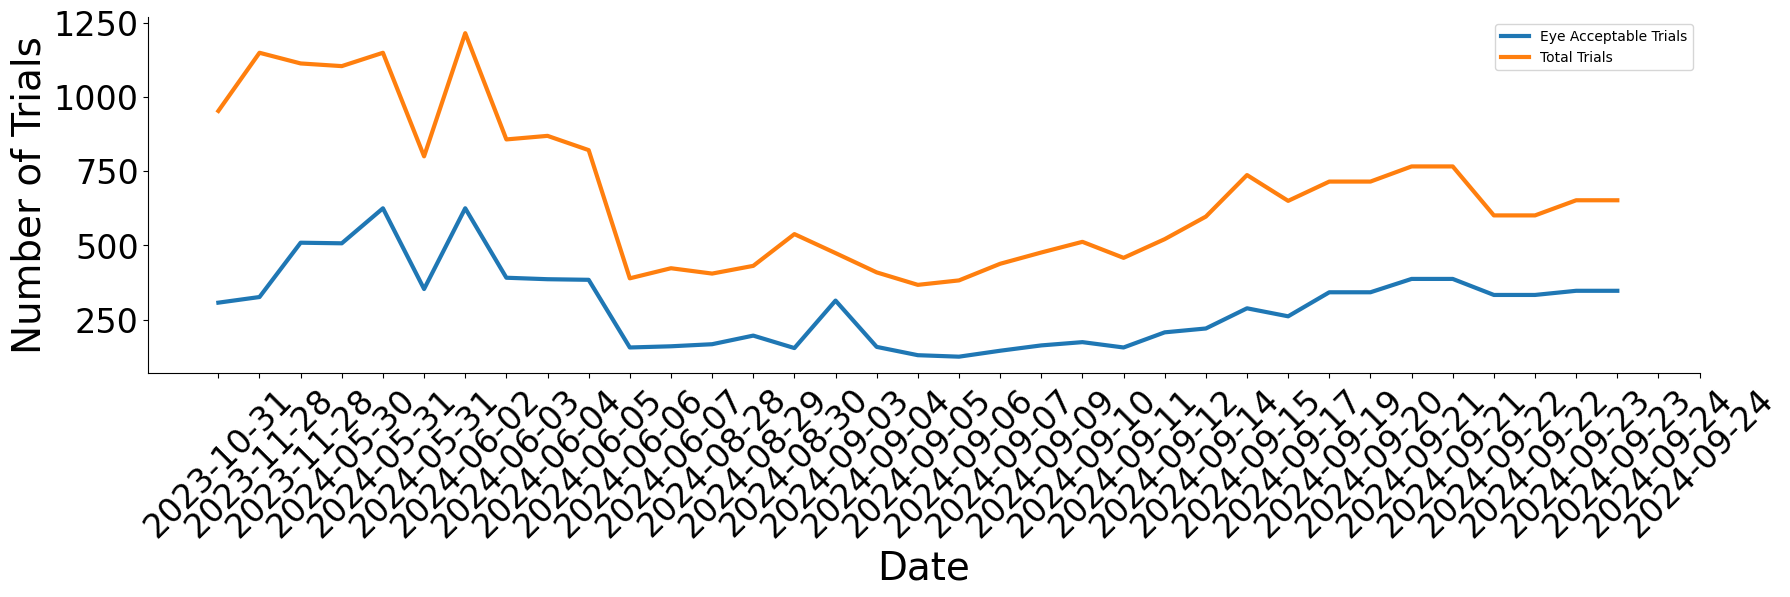

In [17]:
eye_acceptable_trials = []
eye_acceptable_trials_timeseries = []
for ipenetration in range(npenetrations):
    eye_acceptable_trials.append(np.sum(np.logical_and(np.logical_and(df['good_eye_trial'], df['penetration']==ipenetration), df['reward'])))
print(eye_acceptable_trials)
fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.plot(eye_acceptable_trials, label='Eye Acceptable Trials', linewidth=3)
ax.plot(n_mctrials, label='Total Trials', linewidth=3)
ax.set(xlabel='Date', ylabel='Number of Trials')
ax.set_xticks(np.arange(len(dates)), dates, rotation=45)
ax.legend()
fig.tight_layout()
plt.show()

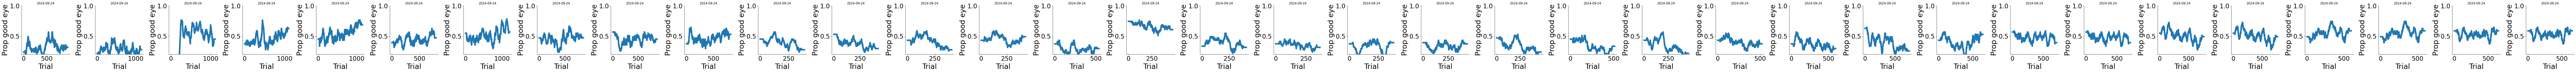

In [18]:
fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*4, 4))
for ipenetration in range(npenetrations):
    ax[ipenetration].plot(aopy.analysis.base.calc_rolling_average(np.array(df['good_eye_trial'][df['penetration']==ipenetration]), window_size=51), linewidth=6)
    ax[ipenetration].set(xlabel='Trial', ylabel='Prop good eye', ylim=(0.2,1), title=f"{date}")
    
fig.tight_layout()
plt.show()

/tmp/ipykernel_2546723/3119141466.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ax.plot(itarget,np.sum(np.array(df['good_eye_trial'][df['target_idx']==(itarget+1)]))/len(np.array(df['good_eye_trial'][df['target_idx']==(itarget+1)])), '.', markersize=16, color=colors[itarget])


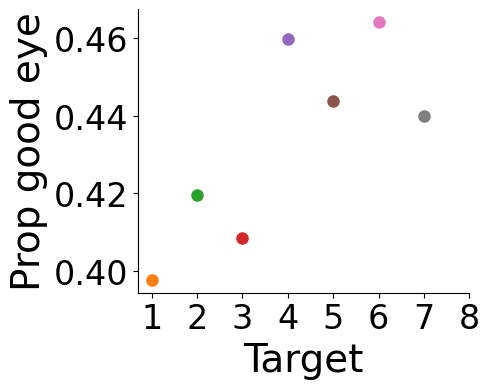

In [19]:
unique_idx = np.unique(df['target_idx'])
fig, ax = plt.subplots(1,1, figsize=(5, 4))
for itarget in np.sort(unique_idx):
    ax.plot(itarget,np.sum(np.array(df['good_eye_trial'][df['target_idx']==(itarget+1)]))/len(np.array(df['good_eye_trial'][df['target_idx']==(itarget+1)])), '.', markersize=16, color=colors[itarget])
    ax.set(xlabel='Target', ylabel='Prop good eye')
    ax.set_xticks(unique_idx, unique_idx)
    
fig.tight_layout()
plt.show()

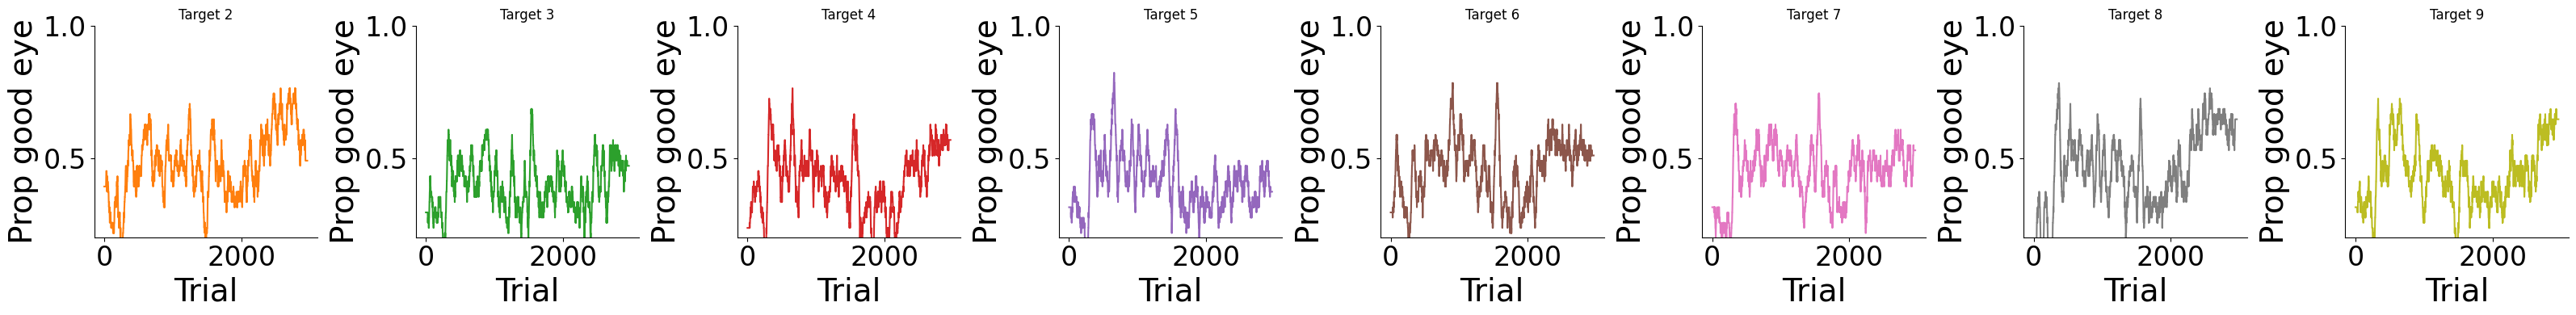

In [20]:
fig, ax = plt.subplots(1,len(unique_idx), figsize=(len(unique_idx)*4, 4))
for itarget in np.sort(unique_idx):
    ax[itarget-1].plot(aopy.analysis.base.calc_rolling_average(np.array(df['good_eye_trial'][df['target_idx']==(itarget)]), window_size=51), color=colors[itarget])
    ax[itarget-1].set(xlabel='Trial', ylabel='Prop good eye', ylim=(0.2,1), title=f"Target {itarget+1}")
    
fig.tight_layout()
plt.show()

/tmp/ipykernel_2546723/262932590.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[ipenetration].legend()


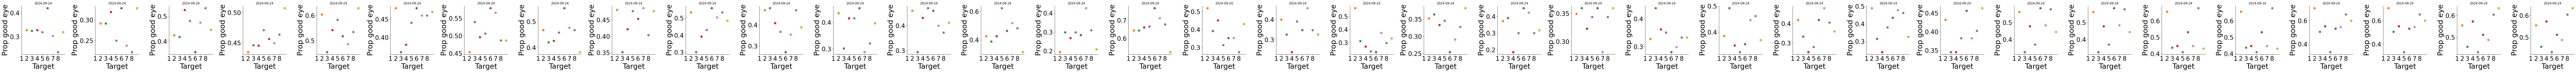

In [21]:
fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*4, 4))
for ipenetration in range(npenetrations):
    for target_idx in np.sort(unique_idx):
        ax[ipenetration].plot(target_idx,np.sum(np.array(df['good_eye_trial'][(df['penetration']==ipenetration)*(df['target_idx']==target_idx)]))/len(np.array(df['good_eye_trial'][(df['penetration']==ipenetration)*(df['target_idx']==target_idx)])), '.', markersize=16, color=colors[target_idx])
        ax[ipenetration].set(xlabel='Target', ylabel='Prop good eye',  title=f"{date}")
        ax[ipenetration].set_xticks(np.arange(ntargets), np.arange(ntargets)+1)

ax[ipenetration].legend()
fig.tight_layout()
plt.show()

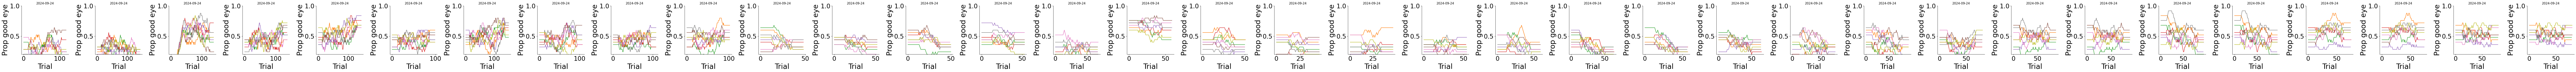

In [22]:
fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*4, 4))
for ipenetration in range(npenetrations):
    for target_idx in np.sort(unique_idx):
        ax[ipenetration].plot(aopy.analysis.base.calc_rolling_average(np.array(df['good_eye_trial'][(df['penetration']==ipenetration)*(df['target_idx']==target_idx)]), window_size=25), color=colors[target_idx], label=f"{target_idx}")
        ax[ipenetration].set(xlabel='Trial', ylabel='Prop good eye', ylim=(0.2,1), title=f"{date}")
# ax[ipenetrations].legend()
fig.tight_layout()
plt.show()

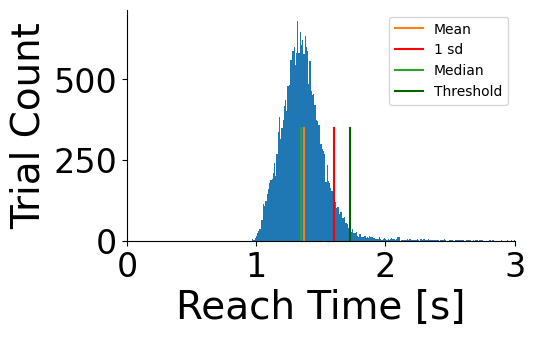

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.hist(np.hstack(reach_times), bins=2000)
ax.set(xlim=[0, 3], xlabel='Reach Time [s]', ylabel='Trial Count')
ax.plot([np.mean(np.hstack(reach_times)), np.mean(np.hstack(reach_times))], [0, 350], label='Mean')
ax.plot([np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times)),np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times))], [0, 350],
        color='red', label='1 sd')
ax.plot([np.median(np.hstack(reach_times)), np.median(np.hstack(reach_times))], [0, 350], label='Median')
ax.plot([reach_time_thresh, reach_time_thresh], [0, 350], color='darkgreen', label='Threshold')
plt.legend()
plt.show()

### Plot behavioral data

### Trajectories and reach times for each day

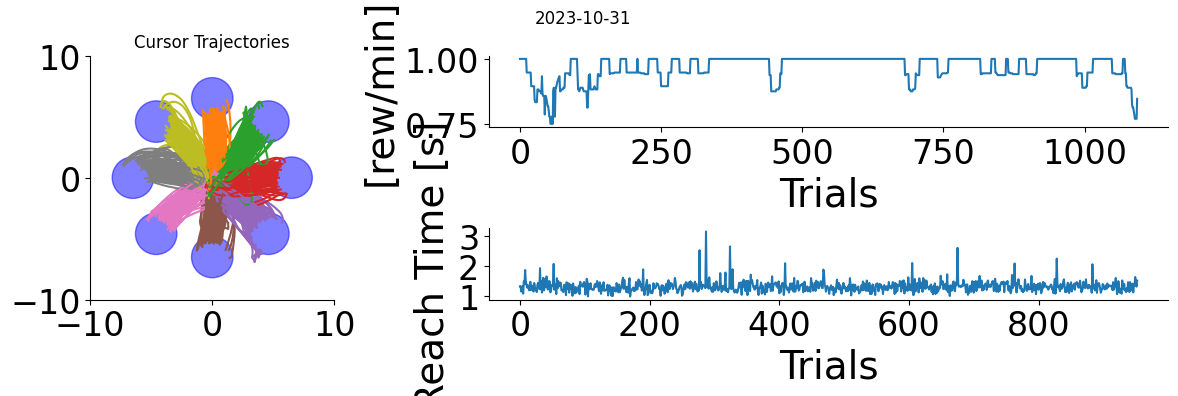

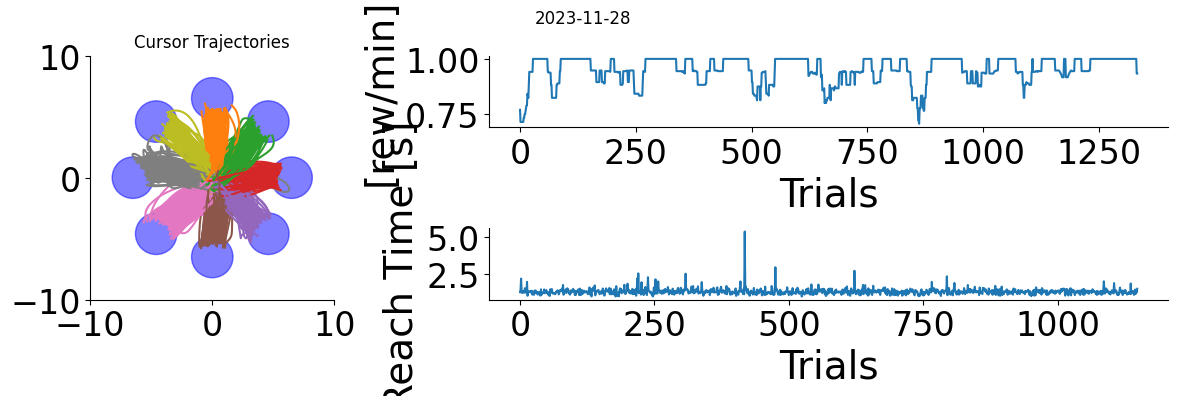

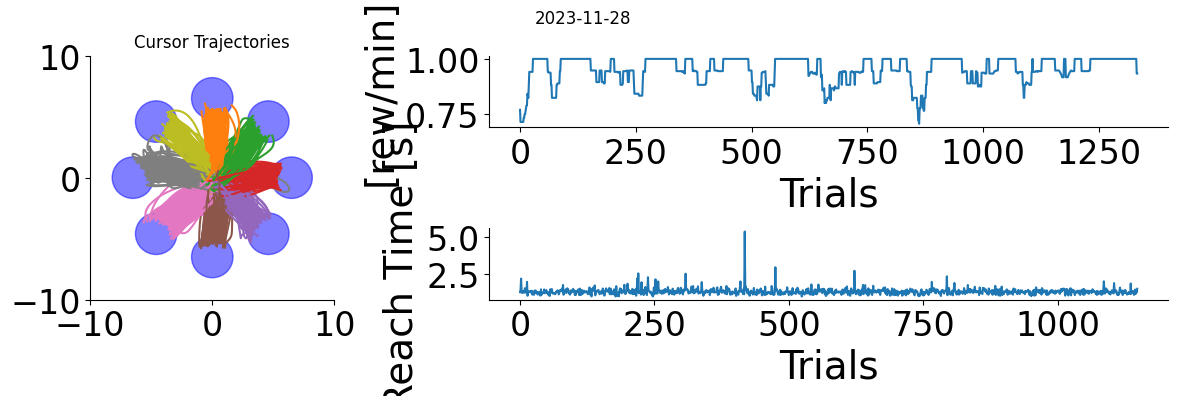

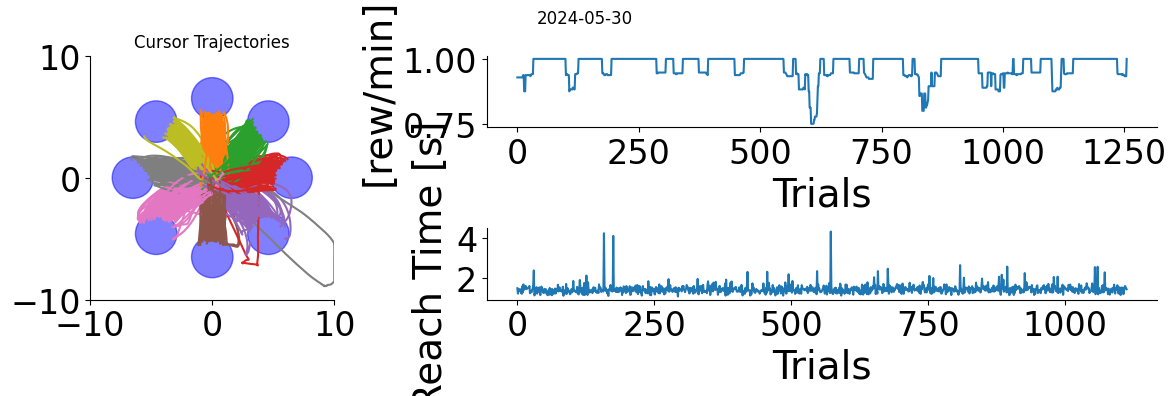

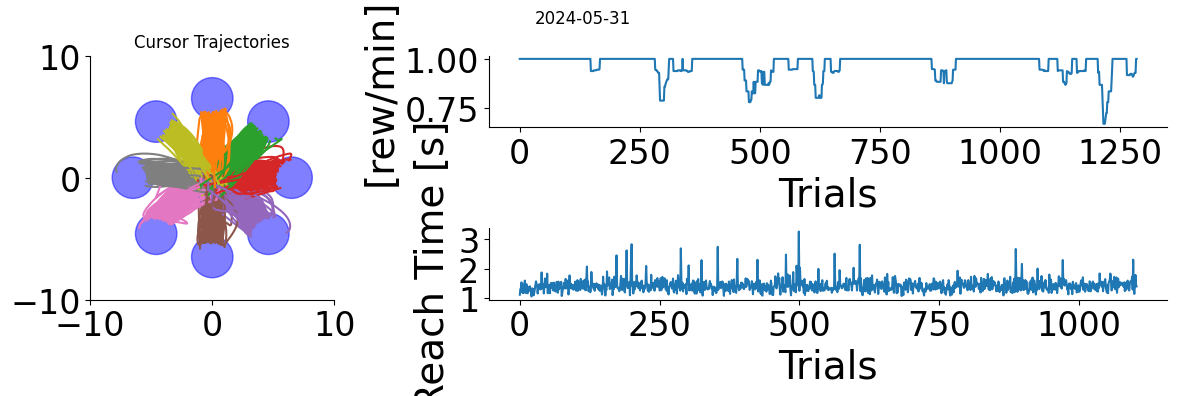

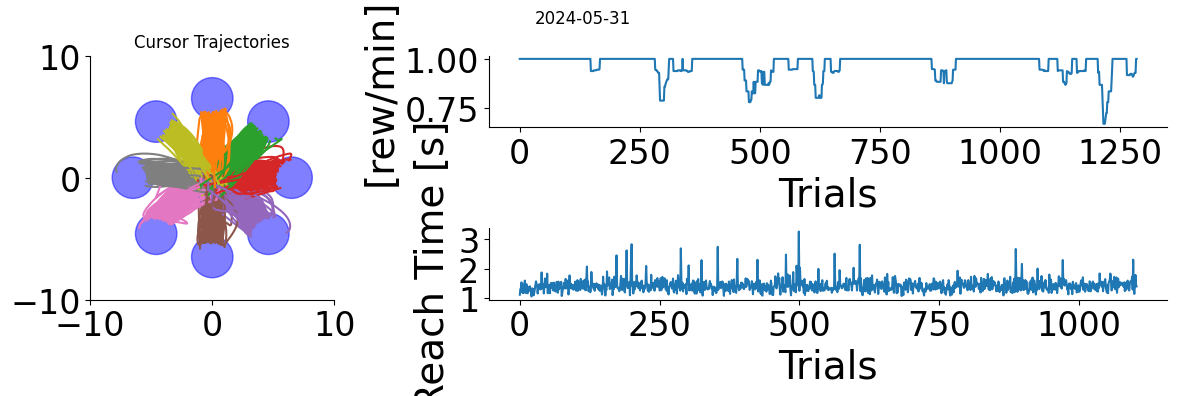

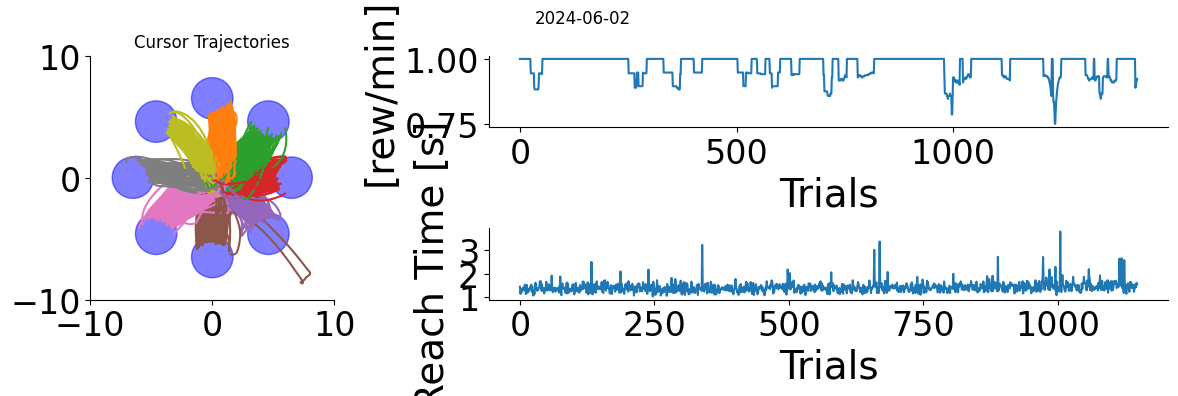

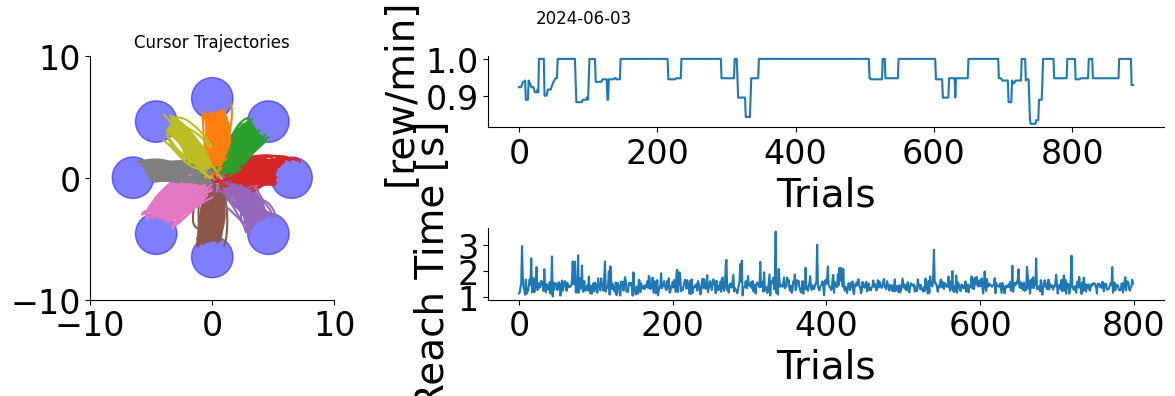

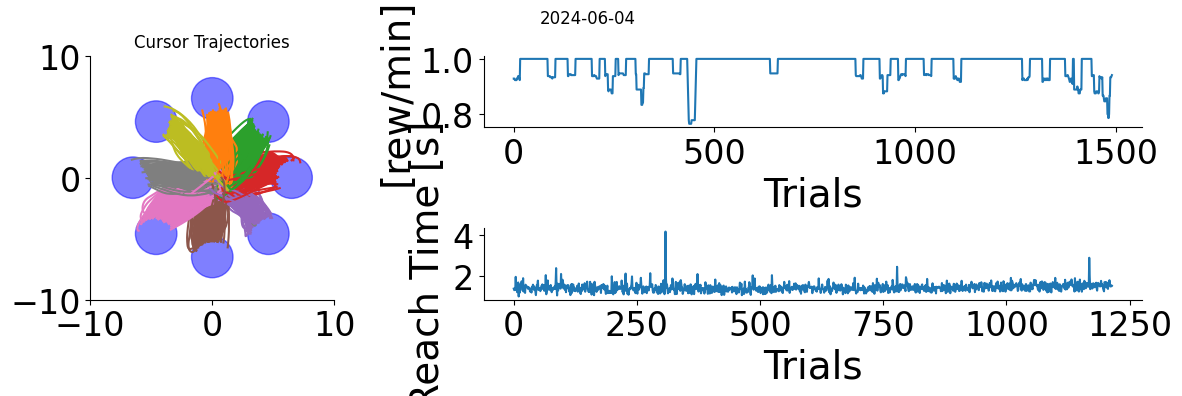

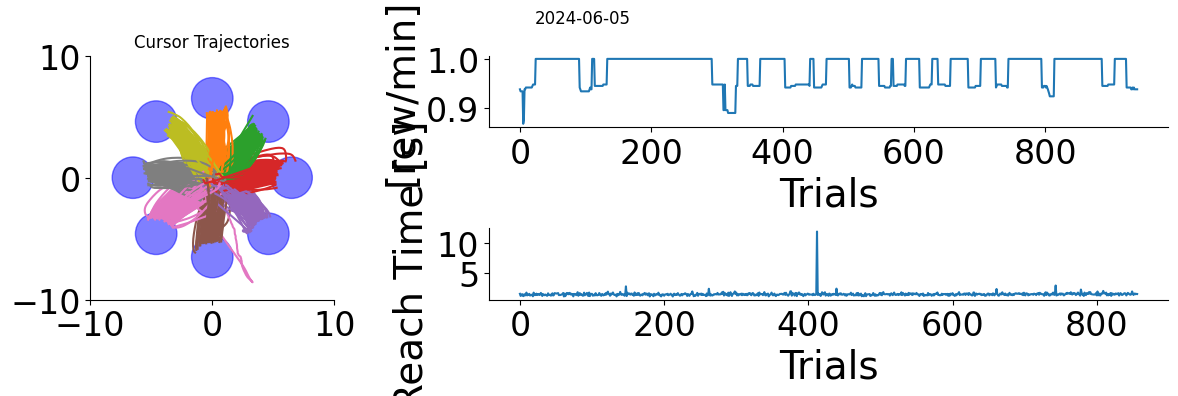

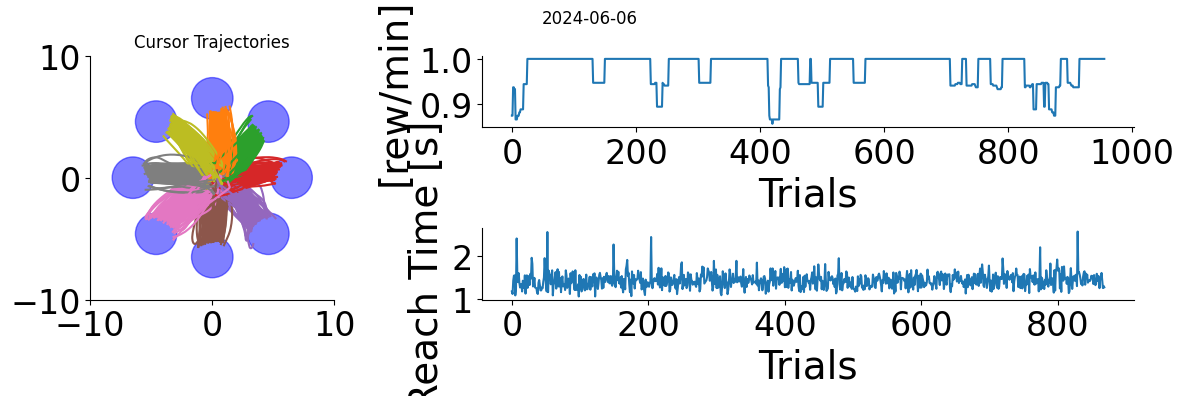

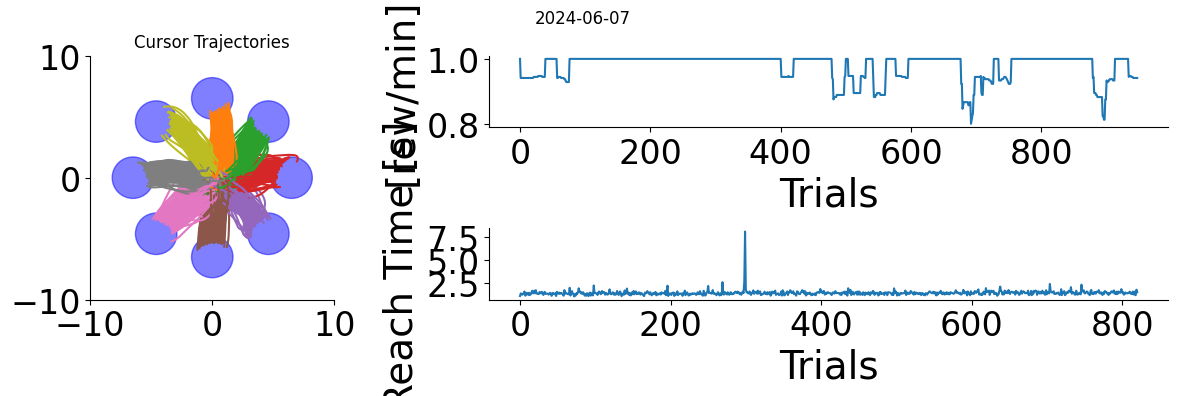

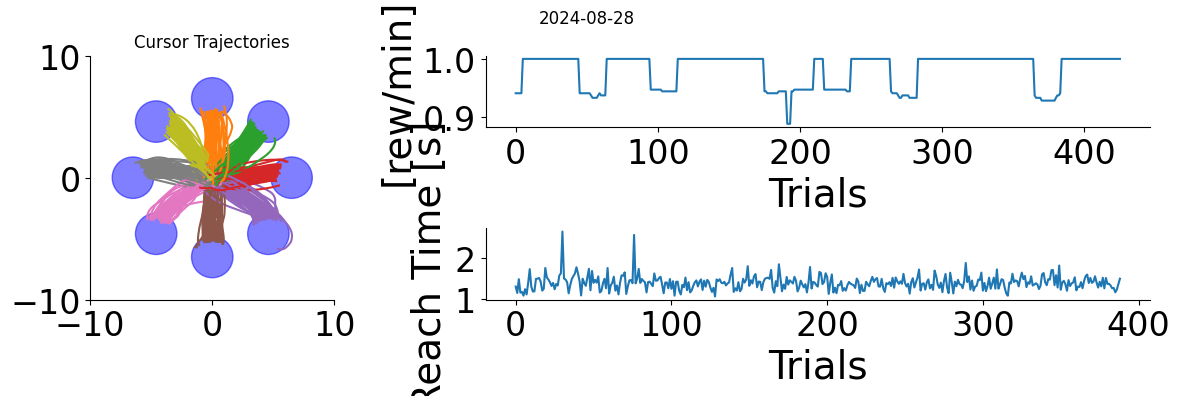

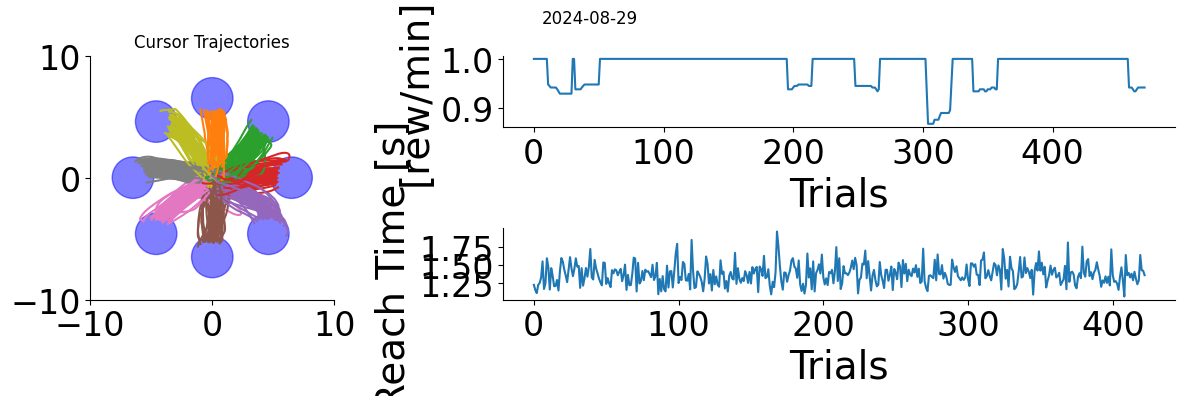

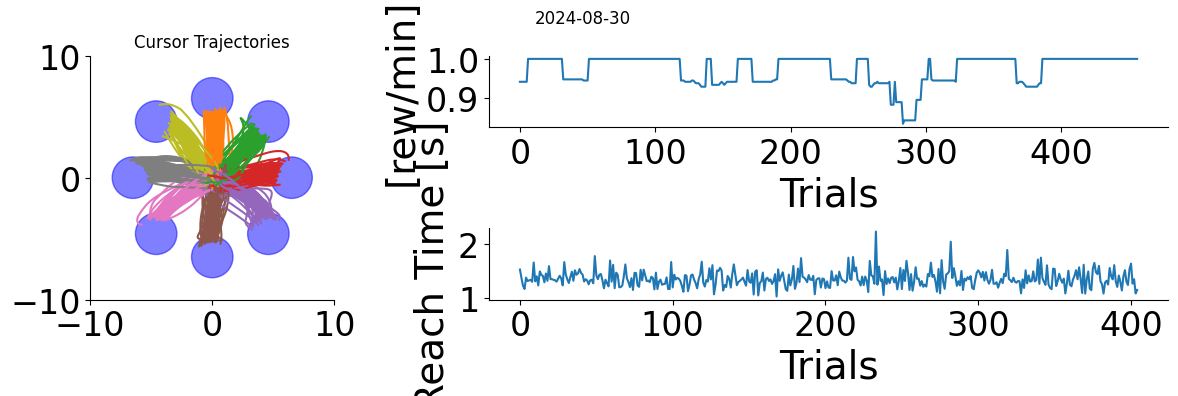

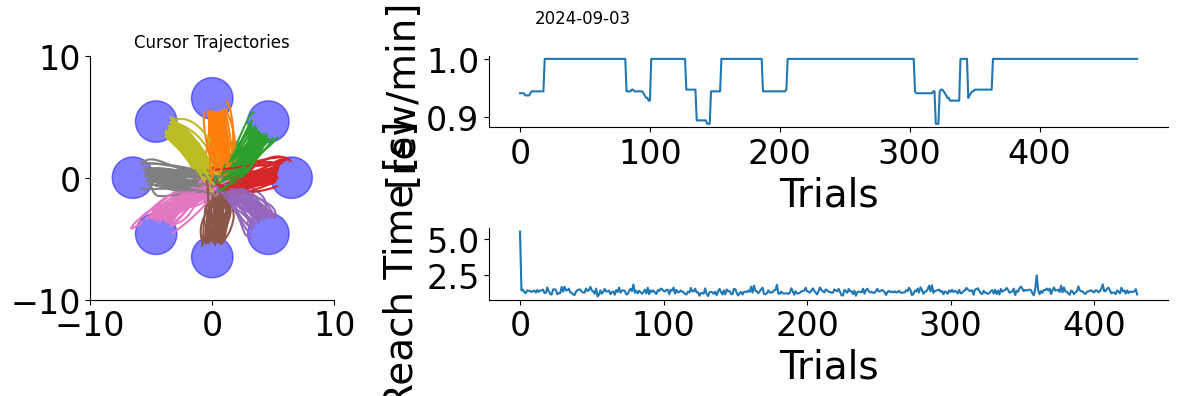

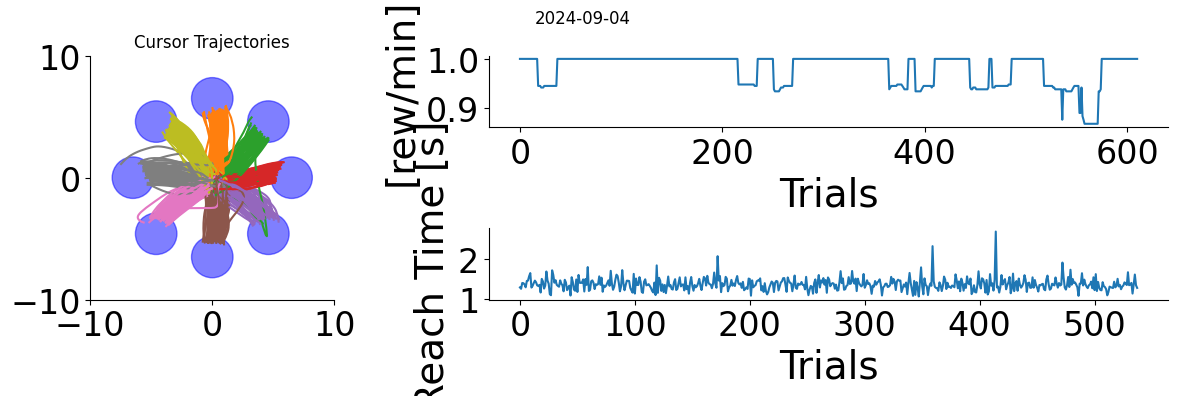

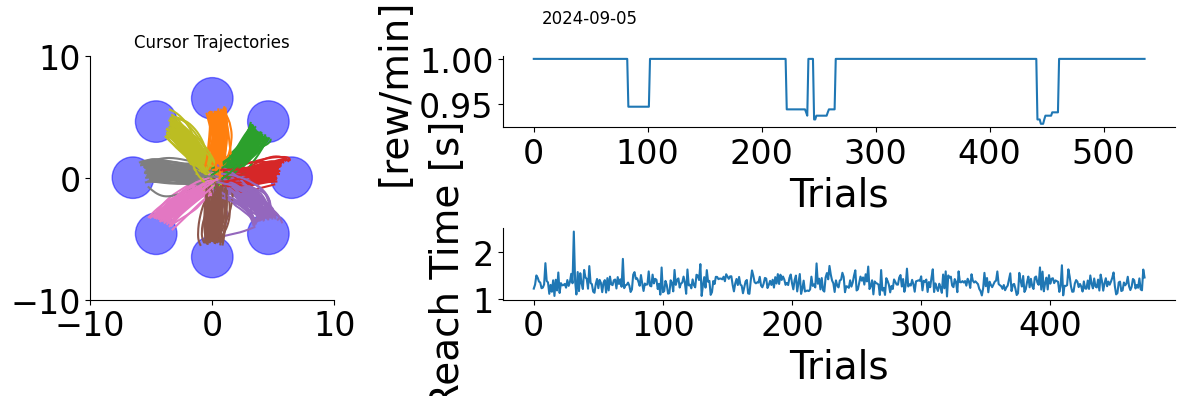

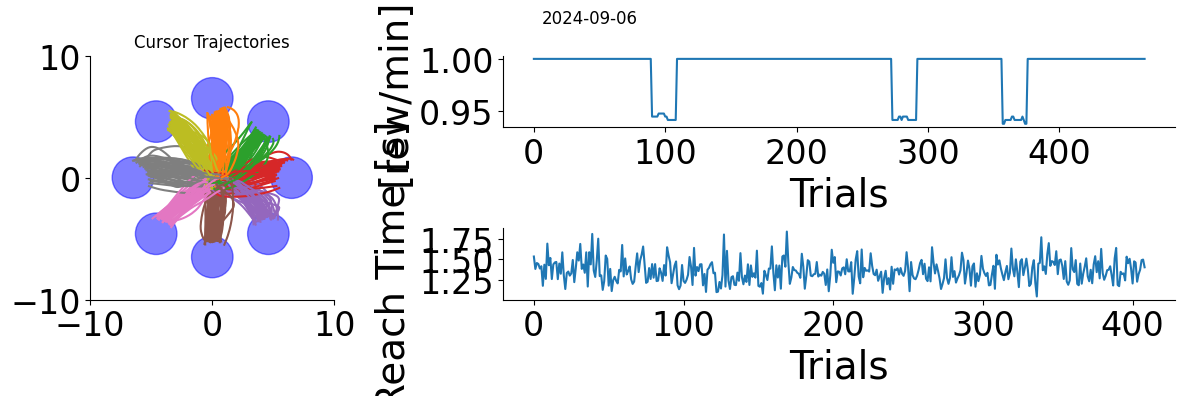

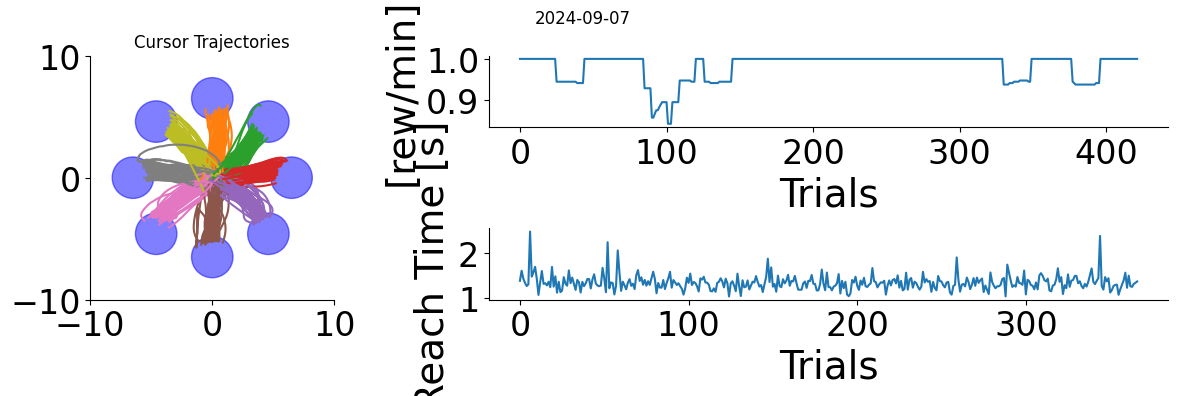

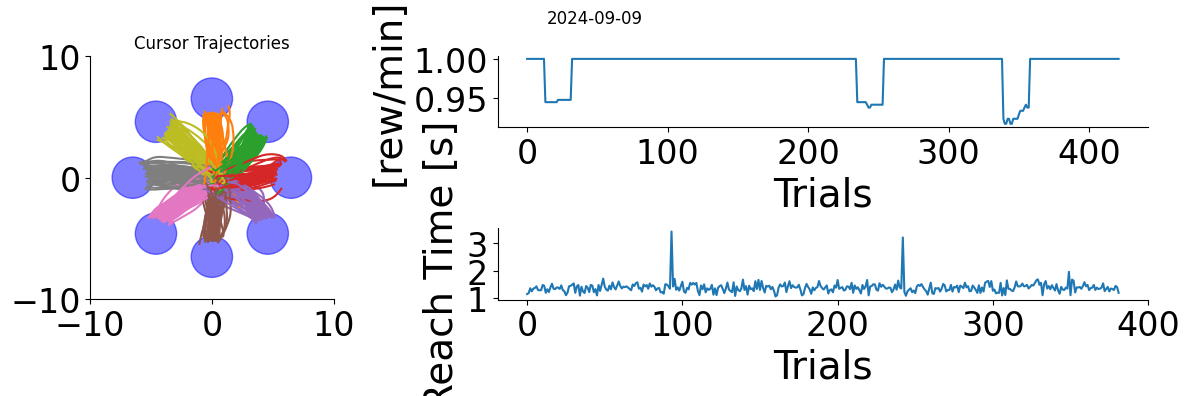

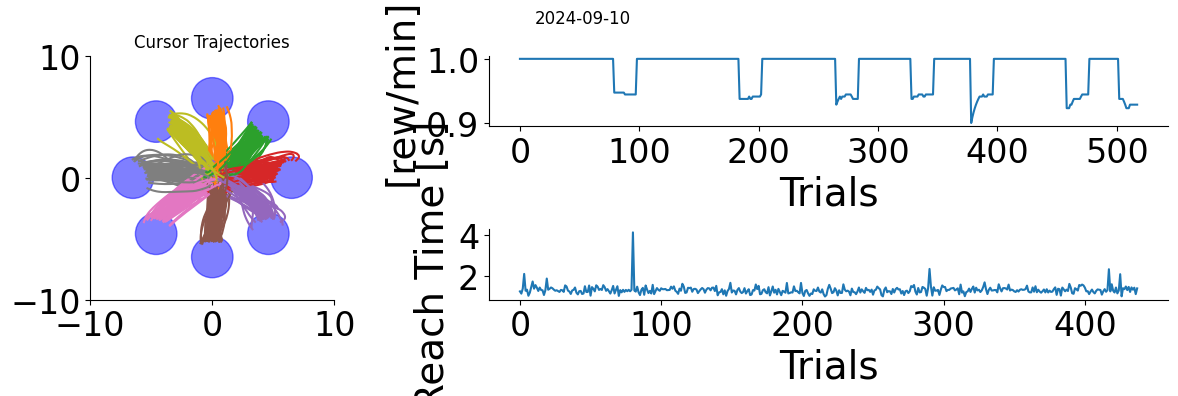

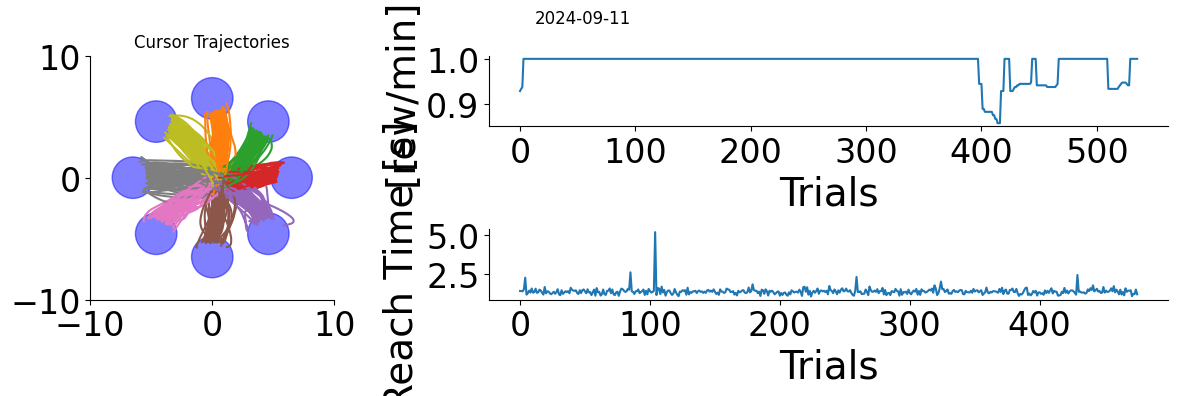

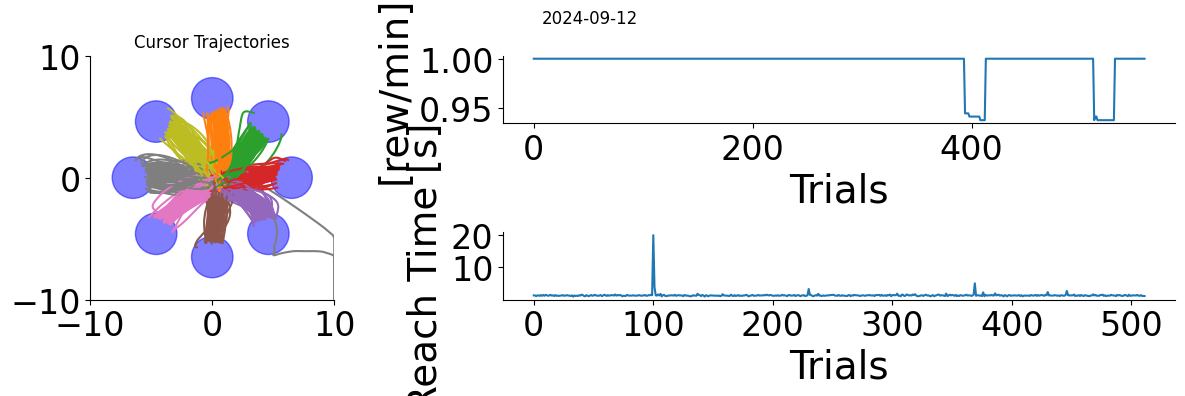

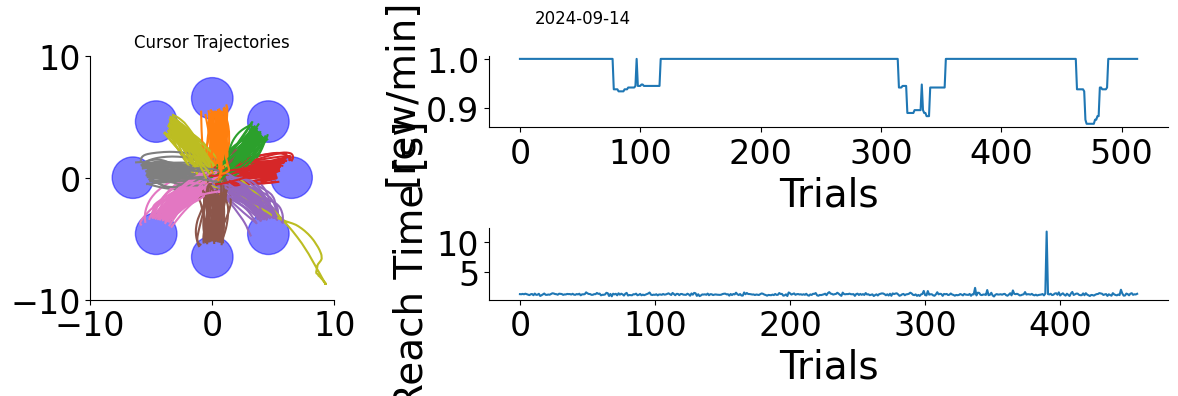

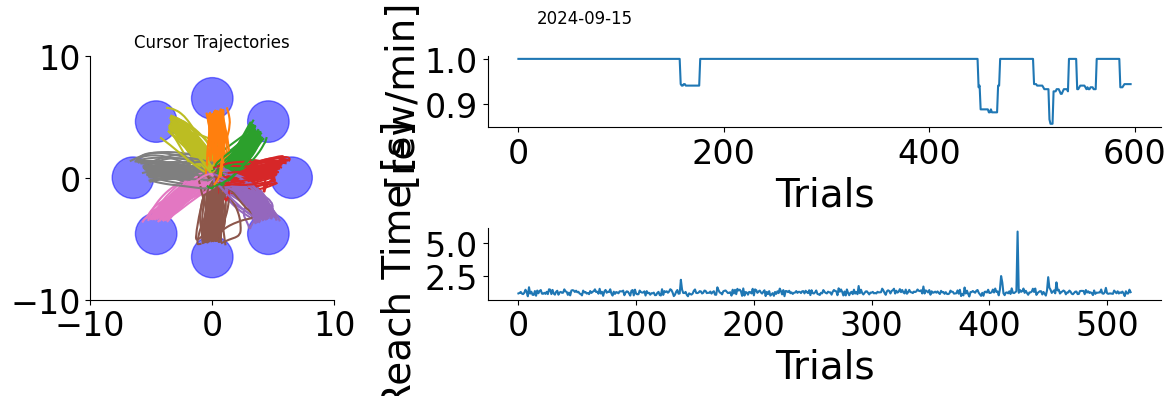

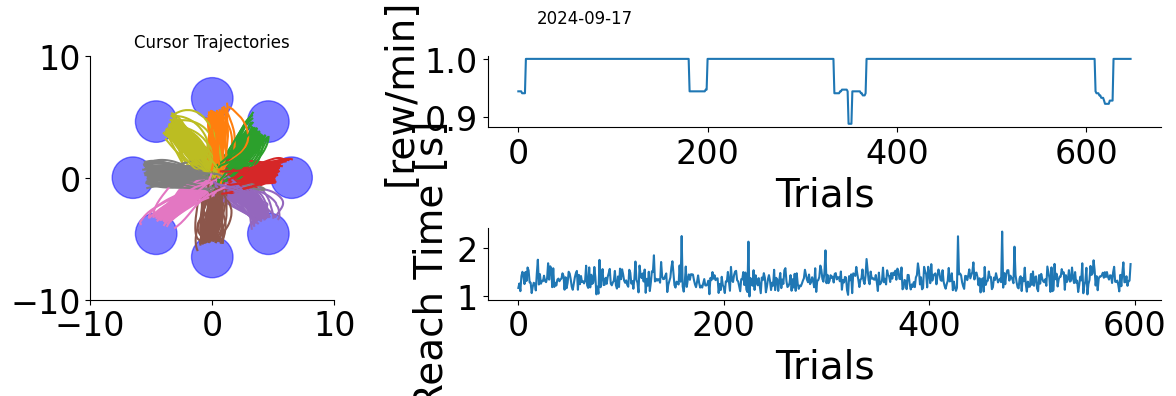

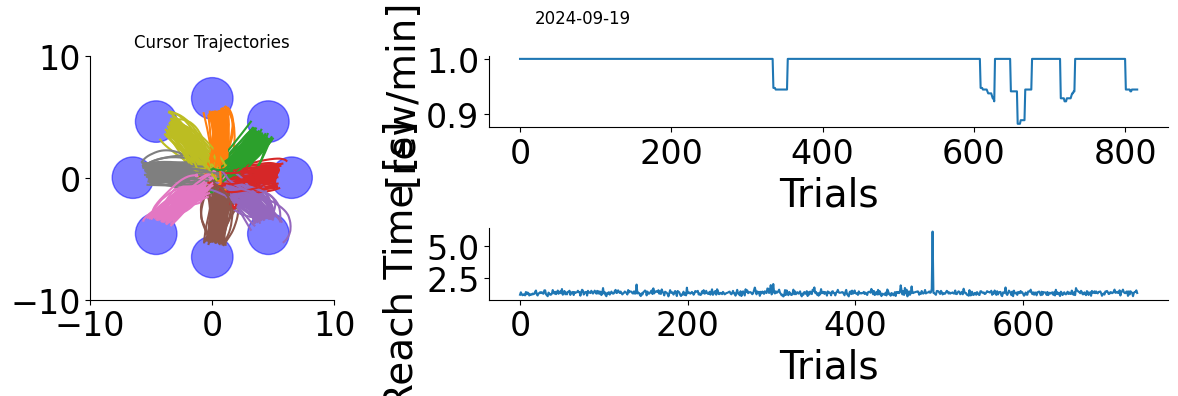

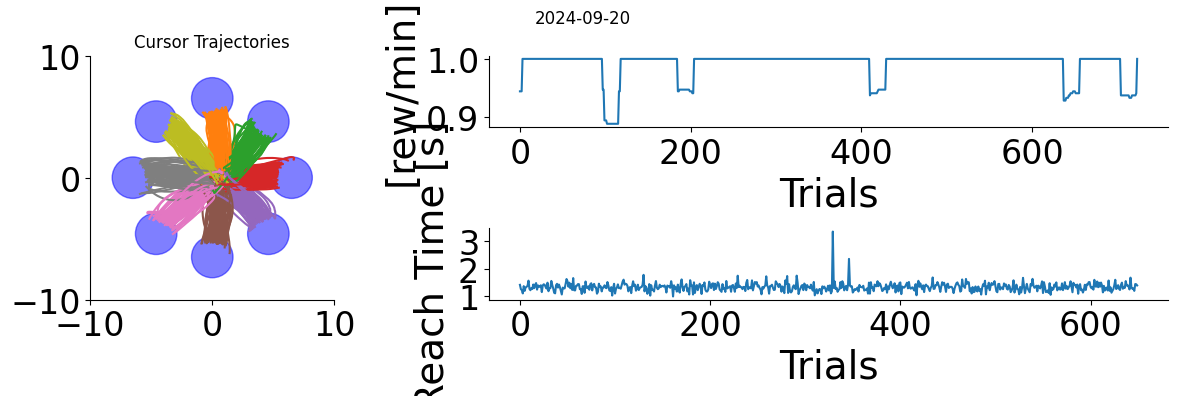

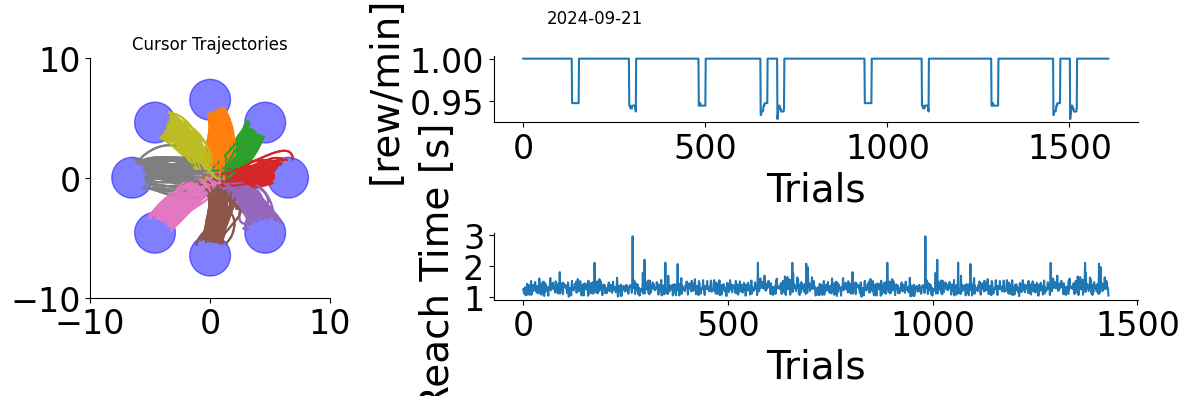

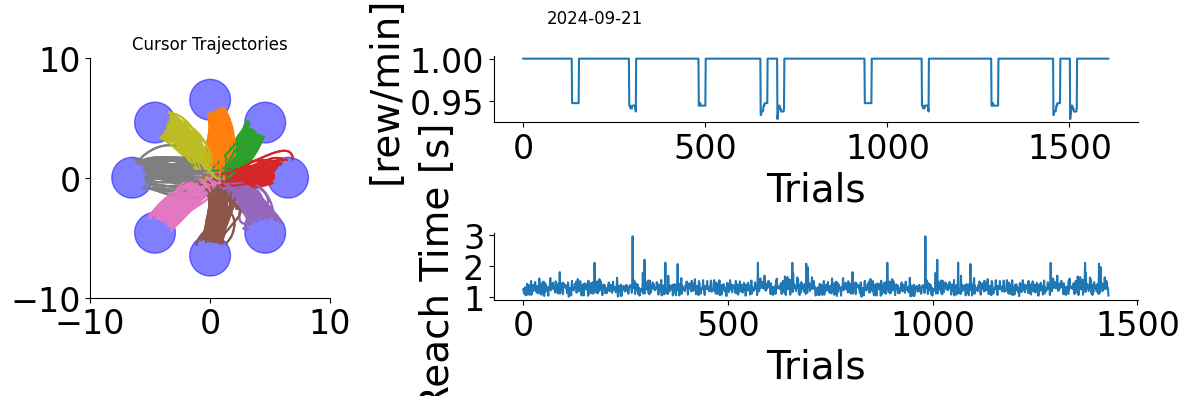

In [ ]:
# All trials
samplerate = 1000
# go_cue_idx = np.ceil((df['go_cue_time'] - df['start_time'])*samplerate).astype(int)
# go_cue_idx = np.array(df['mov_onset_kin_idx'])
go_cue_idx = np.array(df['go_cue_kin_idx']).astype(int)
trial_end_idx = np.ceil((df['reach_end_time'] - df['start_time'])*samplerate).astype(int)
for idate, date in enumerate(dates):
    fig, ax = plt.subplot_mosaic("ABB;ACC",figsize=(12,4))
    labels=np.array(df['target_idx'][df['date']==date])
    traj = [temp_traj[np.array(go_cue_idx[df['date']==date])[itraj]:np.array(trial_end_idx[df['date']==date])[itraj],:] for itraj, temp_traj in enumerate(df['cursor_traj'][df['date']==date])]
    aopy.visualization.color_trajectories(traj, labels, colors=colors, ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, df['target_radius'][0], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot success rate
    # ax['B'].plot(np.arange(success_rate_window/2, n_mctrials[idate]-(success_rate_window/2)+1), success_rate[idate])
    ax['B'].plot(np.arange(success_rate[success_rate_date_labels==date].shape[0]), success_rate[success_rate_date_labels==date])
    ax['B'].set(xlabel='Trials', ylabel='[rew/min]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    # Plot reach time
    ax['C'].plot(np.array(df['duration'][df['date']==date]))
    ax['C'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['C'].spines.right.set_visible(False)
    ax['C'].spines.top.set_visible(False)
    plt.suptitle(date)
    fig.tight_layout()
    plt.show()
    # if save_figs:
    #     aopy.visualization.savefig(full_save_dir, subject+'_mc_behavior.svg')   

In [ ]:
# With bad trials removed from trajectories and reach times.
for idate, date in enumerate(dates):
    fig, ax = plt.subplot_mosaic("ABB",figsize=(12,4))
    labels=np.array(df['target_idx'][df['date']==date])[df['good_trial'][df['date']==date]].astype(int)
    style = plt.cycler(color=[colors[i] for i in labels])
    ax['A'].set_prop_cycle(style)
    traj = [temp_traj[np.array(go_cue_idx[(df['date']==date)*df['good_trial']])[itraj]:np.array(trial_end_idx[(df['date']==date)*df['good_trial']])[itraj],:] for itraj, temp_traj in enumerate(df['cursor_traj'][(df['date']==date)*df['good_trial']])]
    aopy.visualization.plot_trajectories(traj,  ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, df['target_radius'][0], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot reach time
    ax['B'].plot(np.array(df['duration'][df['date']==date])[df['good_trial'][df['date']==date]])
    ax['B'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    plt.suptitle(date)
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot trajectories from multiple days overlapping
traj_colors = ['red', 'black']
fig, ax = plt.subplots(1,1,figsize=(4.5,4.5))
for idate in range(2):
    traj = [temp_traj[np.array(go_cue_idx[(df['date']==date)*df['good_trial']])[itraj]:np.array(trial_end_idx[(df['date']==date)*df['good_trial']])[itraj],:] for itraj, temp_traj in enumerate(df['cursor_traj'][(df['date']==date)*df['good_trial']])]
    aopy.visualization.plot_trajectories(traj,  ax=ax, color=traj_colors[idate], alpha=0.25)

aopy.visualization.plot_targets(unique_targets, df['target_radius'][0], ax=ax)
ax.set(xlabel='', ylabel='', xlim=(-10,10), ylim=(-10,10), xticks=[], yticks=[])
ax.spines[['bottom', 'left']].set_visible(False)
for itarget in range(unique_targets.shape[0]):
    ax.annotate(str(itarget+1), (unique_targets[itarget,0], unique_targets[itarget,1]), fontsize=24, ha='center', va='center')
ax.set_aspect('equal')
aopy.visualization.savefig(save_dir, '2day_traj_comp.svg')

### Summary statistics

In [ ]:
reach_time_list = [np.array(df['duration'][df['date']==date])[df['good_trial'][df['date']==date]] for date in dates]
# _, pval = scipy.stats.f_oneway(reach_time_list[0], reach_time_list[1], reach_time_list[2], reach_time_list[3], reach_time_list[4])
# print(pval)

# Plot reach time histograms across recordings
fig, ax = plt.subplots(1,1,figsize=(20,3.5))
aopy.visualization.plot_boxplots(reach_time_list, plt_xaxis=np.arange(len(dates)), trendline=False)
ax.set(xlabel='Date', ylabel='Reach Time [s]', ylim=(0.8,2))
ax.set_xticks(np.arange(len(dates)), dates, rotation=30)
plt.show()

In [ ]:
# Plot correlation between recordings for reaches - also probably need to do this for hand traj in 3D
samples_before = 100
samples_after = 400 # ms to plot
from sklearn.feature_selection import r_regression
go_cue_idx = np.array(df['mov_onset_kin_idx']).astype(int)
behavior_corr_x = np.zeros((np.sum(df['good_trial']), np.sum(df['good_trial'])))*np.nan
behavior_corr_y = np.zeros((np.sum(df['good_trial']), np.sum(df['good_trial'])))*np.nan
behavior_corr = np.zeros((np.sum(df['good_trial']), np.sum(df['good_trial'])))*np.nan
trial_labels = np.array(df['target_idx'][df['good_trial']])
traj_corr = np.array([temp_traj[np.array(go_cue_idx[df['good_trial']])[itraj]-samples_before:(np.array(go_cue_idx[df['good_trial']])[itraj]+samples_after),:] for itraj, temp_traj in enumerate(df['cursor_traj'][df['good_trial']])])
behavior_corr = aopy.analysis.behavior.correlate_trajectories(np.swapaxes(np.swapaxes(traj_corr, 0,1), 1,2), verbose=True)

In [ ]:
aopy.utils.release_memory_limit()
ntargets = len(np.unique(trial_labels))
fig, ax = plt.subplots(1, ntargets, figsize=(20,4))
for itarget in range(ntargets):
    ax[itarget].pcolor(behavior_corr[trial_labels==(itarget+1),:][:,trial_labels==(itarget+1)],vmin=0, vmax=1)
    ax[itarget].set(xlabel='Trial', ylabel='Trial', title=f"Target: {itarget}")
    
    daily_behavioral_corr = []
    for iday, date in enumerate(dates):
        tidx_start = iday*(ngood_trials//ntargets)
        tidx_end = (iday+1)*(ngood_trials//ntargets)
        daily_behavioral_corr_temp = np.triu(behavior_corr[trial_labels==(itarget+1)][:,trial_labels==(itarget+1)][tidx_start:tidx_end, tidx_start:tidx_end])
        daily_behavioral_corr_temp[daily_behavioral_corr_temp==0] = np.nan
        daily_behavioral_corr_temp[np.diag(np.diag(daily_behavioral_corr_temp))>0] = np.nan
        daily_behavioral_corr_temp = daily_behavioral_corr_temp.flatten()[~np.isnan(daily_behavioral_corr_temp.flatten())]
        daily_behavioral_corr.append(daily_behavioral_corr_temp)

fig.tight_layout()
plt.show()


In [ ]:
targ_idxs, unique_idx = np.unique(np.vstack(df['target_idx']), axis=0, return_index=True)
ordered_targ_idx = unique_idx[np.sort(targ_idxs)-1]
ordered_targ_loc = np.squeeze(np.vstack(df['target_location'])[ordered_targ_idx,:])

In [ ]:
# Only include axis used in the direction of the target
# This is the trajectory correlation of all trials on the given day to each other trial in the dataset
fig, ax = plt.subplots(1, 1, figsize=(10,3))
daily_behavioral_corr_all = []
for ipenetration in range(npenetrations):
    daily_behavioral_corr = []
    for itarget in range(ntargets):
        # direction_mask = ordered_targ_loc[itarget,:] != 0
        tidx_start = ipenetration*(ngood_trials//ntargets)
        tidx_end = (ipenetration+1)*(ngood_trials//ntargets)
        # if direction_mask[0] and direction_mask[1]: # If target uses both X and Y
        daily_behavioral_corr_temp = np.triu(behavior_corr[trial_labels==(itarget+1)][:,trial_labels==(itarget+1)][tidx_start:tidx_end, tidx_start:tidx_end])
        daily_behavioral_corr_temp[daily_behavioral_corr_temp==0] = np.nan
        daily_behavioral_corr_temp[np.diag(np.diag(daily_behavioral_corr_temp))>0] = np.nan
        daily_behavioral_corr_temp = daily_behavioral_corr_temp.flatten()[~np.isnan(daily_behavioral_corr_temp.flatten())]
        daily_behavioral_corr.extend(daily_behavioral_corr_temp)

    daily_behavioral_corr_all.append(daily_behavioral_corr)

bplt = ax.boxplot(daily_behavioral_corr_all, showfliers=False, positions = np.arange(npenetrations))
penetration_dates = [list(df['date'][df['penetration'] == ipenetration])[0] for ipenetration in range(npenetrations)]
ax.set_xticks(np.arange(len(penetration_dates)), penetration_dates, rotation=30)
ax.set(xlabel='Recording Day', ylabel='Trajectory correlation', ylim=(0.5,1))

fig.tight_layout()
plt.show()

In [ ]:
# Only include axis used in the direction of the target
daily_behavioral_corr_mat = np.zeros((npenetrations, npenetrations, ntargets))*np.nan
ntrial_per_day = behavior_corr.shape[0]//npenetrations
behavioral_corr_trial_date_labels = [np.arange(iday*ntrial_per_day,(iday+1)*ntrial_per_day) for iday in range(npenetrations)]

for ipenetration in range(npenetrations):
    for ipenetration2 in range(npenetrations):
        for itarget in range(ntargets):
            direction_mask = ordered_targ_loc[itarget,:] != 0 # Direction of the target
            tidx_start = ipenetration*(ngood_trials//ntargets)
            tidx_end = (ipenetration+1)*(ngood_trials//ntargets)
            trial_mask = np.zeros(behavior_corr.shape[0], dtype=bool)
            trial_mask2 = np.zeros(behavior_corr.shape[0], dtype=bool)
            trial_mask[behavioral_corr_trial_date_labels[ipenetration]] = trial_labels[behavioral_corr_trial_date_labels[ipenetration]]==(itarget+1)
            trial_mask2[behavioral_corr_trial_date_labels[ipenetration2]] = trial_labels[behavioral_corr_trial_date_labels[ipenetration2]]==(itarget+1)
            
            # if direction_mask[0] and direction_mask[1]: # If target uses both X and Y
            daily_behavioral_corr_temp = np.triu(behavior_corr[trial_mask,:][:,trial_mask2])
            daily_behavioral_corr_temp[daily_behavioral_corr_temp==0] = np.nan
            daily_behavioral_corr_temp[np.diag(np.diag(daily_behavioral_corr_temp))>0] = np.nan
            daily_behavioral_corr_temp = daily_behavioral_corr_temp.flatten()[~np.isnan(daily_behavioral_corr_temp.flatten())]
            
            daily_behavioral_corr_mat[ipenetration,ipenetration2,itarget] = np.mean(daily_behavioral_corr_temp)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.mean(daily_behavioral_corr_mat, axis=(0,1)), 'k', linewidth=4)
ax.fill_between(np.arange(ntargets), np.mean(daily_behavioral_corr_mat, axis=(0,1)) - np.std(daily_behavioral_corr_mat, axis=(0,1)), np.mean(daily_behavioral_corr_mat, axis=(0,1)) + np.std(daily_behavioral_corr_mat, axis=(0,1)), color='black', alpha=0.5)
ax.set(xlabel='Target', ylabel='Average r', ylim=(0.5, 1))
ax.set_xticks(np.arange(ntargets), np.arange(ntargets)+1)
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,ntargets,figsize=(50,5))
for itarget in range(ntargets):
    corr_map = ax[itarget].pcolor(daily_behavioral_corr_mat[:,:,itarget], vmin=0.7, vmax=1, cmap='Greys')
    cb = plt.colorbar(corr_map, label='Trajecotry Corr')
    # cb.set_ticks([0.7, 0.8,0.9, 1])
    # ax.set_xticks(np.arange(0, len(dates),2)+0.5, np.arange(0, len(dates),2)+1)
    # ax.set_yticks(np.arange(0, len(dates),2)+0.5, np.arange(0, len(dates),2)+1)
    ax[itarget].set_xticks(np.array([0, len(dates)-1])+0.5, np.array([1, len(dates)]))
    ax[itarget].set_yticks(np.array([0, len(dates)-1])+0.5, np.array([1, len(dates)]))
    ax[itarget].set(xlabel='Recording Day', ylabel='Recording Day', title=f"Target {itarget+1}")
    ax[itarget].set_aspect('equal')
    ax[itarget].grid(False)
fig.tight_layout()
# aopy.visualization.savefig(save_dir, subject+'_mc_behavior_traj_corr.svg') 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
corr_map = ax.pcolor(np.mean(daily_behavioral_corr_mat, axis=2), vmin=0.8, vmax=1, cmap='Greys')
cb = plt.colorbar(corr_map, label='Trajectory Corr')
cb.set_ticks([0.8,1])
# ax.set_xticks(np.arange(0, len(dates),2)+0.5, np.arange(0, len(dates),2)+1)
# ax.set_yticks(np.arange(0, len(dates),2)+0.5, np.arange(0, len(dates),2)+1)
ax.set_xticks(np.array([0, npenetrations-1])+0.5, np.array([1, npenetrations]))
ax.set_yticks(np.array([0, npenetrations-1])+0.5, np.array([1, npenetrations]))
ax.set(xlabel='Recording Day', ylabel='Recording Day')
ax.set_aspect('equal')
ax.grid(False)
fig.tight_layout()
aopy.visualization.savefig(save_dir, subject+'_mc_behavior_traj_corr.svg') 

# Load neuropixel spiking data

In [ ]:
def load_neuropixel_data(preproc_dir, subject, teid, date, data_name):
    if teid < 18000:
        filename_mc = aopy.data.get_preprocessed_filename(subject, teid, date, 'ap')
        try:
            data = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename_mc, data_name)
        except:
            print(f"Could not load data. (TE: {teid}, Date: {date}) - Can only load data_name='ap' or data_name='metadata for this teid'")
            
    else:
        filename_mc = aopy.data.get_preprocessed_filename(subject, teid, date, 'ap')
        filename_mc = filename_mc[:-6] + 'spike.hdf'
        try:
            data = aopy.data.load_hdf_group(os.path.join(preproc_dir, subject), filename_mc, data_name)
        except:
            print(f"Could not load data. (TE: {teid}, Date: {date})")
    
    return data

In [ ]:
# print(spike_data.keys(), spike_data['drive1'].keys())
# temp_save_dir = f"/media/moor-data/postprocessed/{subject}/"
# temp_spike_data = {}
# temp_spike_data['drive1'] = {}
# temp_spike_data['drive2'] = {}
# temp_spike_data['drive1']['spikes'] = spike_data['drive1']['spikes']
# temp_spike_data['drive2']['spikes'] = spike_data['drive2']['spikes']
# # print(temp_spike_data.keys(), temp_spike_data['drive1'].keys())
# # aopy.data.base.save_hdf(temp_save_dir, 'preproc_2024-09-23_affi_18378_spike.hdf', temp_spike_data, append=True)

# # save all data into hdf file
# filepath = os.path.join(temp_save_dir, 'preproc_2024-09-23_affi_wftest_spike.hdf')
# with h5py.File(filepath, 'a', track_order=True) as hdf:
# # hdf = h5py.File(filepath, 'a', track_order=True)
#     for port_number in range(1,3):
#         print(port_number)

#         spike_group = hdf.create_group(f'drive{port_number}/spikes', track_order=True)
#         wf_group = hdf.create_group(f'drive{port_number}/waveforms', track_order=True)
#         metadata_group = hdf.create_group(f'drive{port_number}/metadata', track_order=True)
        
#         for iunit in np.unique(list(temp_wfs.keys())):
#             spike_group.create_dataset(f'{iunit}',data=temp_spike_times[iunit])
#             wf_group.create_dataset(f'{iunit}',data=temp_wfs[iunit])
            
            
#         for key in relevant_metadata_keys:
#             metadata_group.create_dataset(f'{key}', data=ap_metadata[key])

# # hdf.close()

In [ ]:
ntime = np.round((tafter_mc + tbefore_mc)/spike_bin_width_mc).astype(int)
trial_time_axis = np.arange(-tbefore_mc, tafter_mc, spike_bin_width_mc)
ntargets = len(np.unique(df['target_idx']))

In [ ]:
 # ap_data, ap_metadata = aopy.data.load_preproc_spike_data(data_path_preproc, subject, me.id, me.date.date(),drive_number=isite)

In [ ]:
# Concatenate trials across sessions within a day
# TODO: concatenatmc_entries if recorded at the same stim site but during different days
start = time.time()
spike_times = []
unit_labels = []
trial_times = []
spike_segs = []
spike_align = []
spike_align_raster = []
spike_labels = []
spike_pos = []
ks_labels = []
recording_site = []
implant_name = []
df['implant_name'] = ''

for ime, me in enumerate(tqdm(mc_entries)):
    ########################################################
    ### FUNCTION 1 - concatenate spike times across sessions
    ########################################################

    # Load data from sessions recorded on the same day and combine 
    # Load data
    exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, me.id, me.date.date())
    
    # Compute how many drives were used
    entry_recording_sites = np.array([exp_metadata['neuropixel_port1_site'], exp_metadata['neuropixel_port2_site']])
    entry_nsites = np.sum(entry_recording_sites > 0)
    
    for isite in range(1, entry_nsites+1):        
        if me.id < 1:
            filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'ap')
            try:
                ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')
                ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'metadata')
                unit_labels.append(ap_data['unique_label'])
                spike_times.append(ap_data['unit']) # Assumes spike labels are consistent across recording sessions (works if recorded on the same day, but otherwise it does not)
                spike_pos.append(ap_data['pos'])
            except:
                print(f"Could not load data. (TE: {me.id}, Date: {me.date.date()})")
                continue
        else:
            filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'spike')
            # try:
            # ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, f'drive{isite}/spikes')
            # ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, f'drive{isite}/metadata')
            ap_data, ap_metadata = aopy.data.load_preproc_spike_data(data_path_preproc, subject, me.id, me.date.date(),drive_number=isite)
            # spike_pos_temp = ap_metadata['spike_pos']
            unit_labels.append(ap_metadata['unique_label'])
            spike_times.append(ap_data) # Assumes spike labels are consistent across recording sessions (works if recorded on the same day, but otherwise it does not)
            spike_pos.append(ap_metadata['spike_pos'])
            # except:
            #     print(f"Could not load data. (TE: {me.id}, Date: {me.date.date()})")
            #     continue

        samplerate = exp_metadata['cursor_interp_samplerate']    

        ########################################################

        # df.loc[df['te_id']==me.id, ['recording_site']] = exp_metadata['neuropixel_port1_site']
        df.loc[df['te_id']==me.id, ['implant_name']] = exp_metadata['neuropixel_port1_drive_type']
        # df['recording_site'][df['te_id']==me.id] = exp_metadata['neuropixel_port1_site'] # TODO: quirry this from the db instead of metadata
        # df['implant_name'][df['te_id']==me.id] = me.task_params['neuropixel_port1_drive_type']
        # Fix bmi3d data entry error
        if me.id == 10802:
            df.loc[df['te_id']==me.id, ['recording_site']] = exp_metadata['neuropixel_port1_site']

        ########################################################

        spike_segs_day = {}
        for iunit, unitid in enumerate(unit_labels[-1]):
            binned_spikes, time_bins = aopy.precondition.bin_spike_times(spike_times[-1][str(unitid)], 0, np.array(df['reach_end_time'][df['te_id']==me.id])[-1]+20, spike_bin_width_mc)

            # Align trial segments
            spike_segs_day[str(unitid)] = aopy.preproc.base.get_data_segments(binned_spikes, traj_times[df['te_id']==me.id,:], 1/spike_bin_width_mc)
            # spike_segs_day[str(unitid)] = [smooth_timeseries_gaus(data_segs[itr], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd) for itr in range(len(data_segs))]

        spike_segs.append(spike_segs_day)
        

In [ ]:
# Update unit labels for each trial
unique_ids = np.unique(df['te_id'])
unit_label_list_4df = []
for itrial in tqdm(range(len(df))):
    penetration = int(np.array(df['penetration'])[itrial])
    trial_te_id = np.array(df['te_id'])[itrial]
    unique_unit_labels = np.unique(np.array(df[['te_id','penetration']]), axis=0) # Unique unit labels are loaded for different teid even if they will be combined later.
    unit_labels_2load = np.where(np.sum(np.logical_or(unique_unit_labels == trial_te_id,unique_unit_labels == penetration), axis=1) == 2)[0][0]
    
    unit_label_list_4df.append(unit_labels[unit_labels_2load])
    
    
df['unit_labels'] = pds.Series(unit_label_list_4df, df.index)

In [ ]:
# Combine unit labels for sessions recorded on the same day
for ipenetration in range(npenetrations):
    date = np.array(df['date'][df['penetration']==ipenetration])[0]
    
    # Only necessary if there are multiple TEs from the dame day
    nsessions_day = len(np.unique(df['te_id'][df['penetration']==ipenetration])) 
    if nsessions_day > 1:
        print(date)
        # Get times from the first session to add to.
        sessions_today = np.unique(df['te_id'][df['penetration']==ipenetration])
        baseline_times = {}
        baseline_times['unit_labels'] = np.array(df['unit_labels'][df['te_id']==sessions_today[0]])[0]

        max_time = np.array(df['reach_end_time'][df['te_id']==sessions_today[0]])[-1]
        for isess in range(1,nsessions_day):
            # Update unit labels
            unit_labels_today = np.array(df['unit_labels'][df['te_id']==sessions_today[isess]])[0]
            good_unit_label_mask = np.in1d(baseline_times['unit_labels'], unit_labels_today) # Get units from first session that are also in the second
            baseline_times['unit_labels'] = baseline_times['unit_labels'][good_unit_label_mask] # Upate list of units to keep
        
        # Update unit labels in dataframe
        for itrial in range(len(df)):
            if np.array(df['te_id'])[itrial] in sessions_today:
                df.at[df.index[itrial], 'unit_labels'] = baseline_times['unit_labels']

In [ ]:
# Restructure dictionaries of spike segments and save in dataframe
# Want a list each entry is a dictionary of spike segs. Each entry of the dict is a spike seg
unique_ids = np.unique(df['te_id'])
spike_seg_list_4df = []
for itrial in tqdm(range(len(df))):
    penetration = int(np.array(df['penetration'])[itrial])
    trial_te_id = np.array(df['te_id'])[itrial]
    port = int(np.array(df['port'])[itrial])
    unique_unit_labels = np.unique(np.array(df[['te_id','penetration']]), axis=0).astype(int) # Unique unit labels are loaded for different teid even if they will be combined later.
    unit_labels_2load = np.where(np.sum(np.logical_or(unique_unit_labels == trial_te_id,unique_unit_labels == penetration), axis=1) == 2)[0][0]
    idx_trial = itrial - np.min(np.where(np.array(df['penetration'])==ipenetration))
    
    # trial_te_id = df['te_id'][itrial]
    ite_id = np.where(unique_ids==trial_te_id)[0][0]
    
    if port == 2:
        idx_trial = itrial - np.min(np.where(np.array(df['penetration'])==penetration))
    else:
        idx_trial = itrial - np.min(np.where(np.array(df['te_id'])==trial_te_id))
    
    
    spike_dict = {}
    for iunit, unitid in enumerate(list(list(df['unit_labels'])[itrial])): #Each TE has the same unit labels
        spike_dict[str(unitid)] = spike_segs[unit_labels_2load][str(unitid)][idx_trial]
    # print(spike_segs[ite_id][str(unitid)][idx_trial])
    spike_seg_list_4df.append(spike_dict)
    
df['spike_segs'] = spike_seg_list_4df

## Plot a few rasters 

In [ ]:
def compile_raster(data, trigger_idx, tbefore, tafter, samplerate, unit_data=False, smooth=False):
    '''
    args:
        data(ntrial-list of data dict): Each element of the list is a dictionary with each entry being a (nt) array of binned spikes
        trigger_idx (ntrial):
        tbefore (float):
        tafter (float):
        unit_data (bool): If data is labelled units
        samplerate (int): neural data samplerate
    '''
    
    idx_before = int(np.ceil(tbefore*samplerate))
    idx_after = int(np.ceil(tafter*samplerate))    
    ntrials = len(data)
    ntime = int(idx_before+idx_after)
    
    if unit_data:
        unique_unit_labels = np.sort(np.unique([list(itrial_data.keys()) for itrial_data in data]).astype(int))
        nunits = len(unique_unit_labels)
        raster_array = np.zeros((ntime, ntrials, nunits))*np.nan
    else:
        unique_unit_labels = None
        raster_array = np.zeros((ntime, ntrials, data[0].shape[1]))*np.nan
    
    for itrial in range(ntrials):
        start_idx = int(trigger_idx[itrial]-idx_before)
        end_idx = int(trigger_idx[itrial]+idx_after)
        raster_idx_start = int(0)
        raster_idx_end = ntime
        
        if unit_data:
            trial_len = len(data[itrial][str(unique_unit_labels[0])])
        else:
            trial_len = data[itrial].shape[0]
        
        # Contingency if start_idx < 0 or end_idx is longer than the data segment
        if start_idx < 0:
            print('start_idx < 0')
            raster_idx_start = -start_idx
            start_idx = 0
            
        if end_idx > trial_len:
            print('end_idx < trial_len')
            if unit_data:
                trial_len = len(data[itrial][str(unique_unit_labels[itrial])])
            else:
                trial_len = len(data[itrial][itrial])
            raster_idx_end = int(trial_len - trigger_idx[itrial] + idx_before)
            end_idx = trial_len

        if unit_data:
            for iunit, unit_label in enumerate(unique_unit_labels):
                if smooth:
                    # [smooth_timeseries_gaus(data_segs[itr], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd) for itr in range(len(data_segs))]
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = smooth_timeseries_gaus(data[itrial][str(unit_label)], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd)[start_idx:end_idx]
                else:
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = data[itrial][str(unit_label)][start_idx:end_idx]
                    
        else:
            raster_array[raster_idx_start:raster_idx_end,itrial,:] = data[itrial][start_idx:end_idx,:]
            
    return raster_array, unique_unit_labels

In [ ]:
# Create trial aligned arrays to go cue from spike segments on each day.
rasters = {}
rasters['neural'] = {}
rasters['cursor_pos'] = {}
rasters['cursor_velo'] = {}
rasters['hand_pos'] = {}
rasters['hand_velo'] = {}
rasters['neural']['TARGET ONSET'] = []
rasters['neural']['GO CUE'] = []
rasters['neural']['MOVEMENT ONSET'] = []
rasters['cursor_pos']['TARGET ONSET'] = []
rasters['cursor_pos']['GO CUE'] = []
rasters['cursor_pos']['MOVEMENT ONSET'] = []
rasters['cursor_velo']['TARGET ONSET'] = []
rasters['cursor_velo']['GO CUE'] = []
rasters['cursor_velo']['MOVEMENT ONSET'] = []
rasters['hand_pos']['TARGET ONSET'] = []
rasters['hand_pos']['GO CUE'] = []
rasters['hand_pos']['MOVEMENT ONSET'] = []
rasters['hand_velo']['TARGET ONSET'] = []
rasters['hand_velo']['GO CUE'] = []
rasters['hand_velo']['MOVEMENT ONSET'] = []
# for idate, date in enumerate(tqdm(dates)):
for ipenetration in tqdm(range(npenetrations)):
    rasters['neural']['TARGET ONSET'].append(compile_raster(list(df['spike_segs'][df['penetration']==ipenetration]), np.array(df['delay_start_neural_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    rasters['neural']['GO CUE'].append(compile_raster(list(df['spike_segs'][df['penetration']==ipenetration]), np.array(df['go_cue_neural_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    rasters['neural']['MOVEMENT ONSET'].append(compile_raster(list(df['spike_segs'][df['penetration']==ipenetration]), np.array(df['mov_onset_neural_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=True)[0])
    
    rasters['cursor_pos']['TARGET ONSET'].append(compile_raster(list(df['cursor_traj'][df['penetration']==ipenetration]), np.array(df['delay_start_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0][:,:,:2])
    rasters['cursor_pos']['GO CUE'].append(compile_raster(list(df['cursor_traj'][df['penetration']==ipenetration]), np.array(df['go_cue_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0][:,:,:2])
    rasters['cursor_pos']['MOVEMENT ONSET'].append(compile_raster(list(df['cursor_traj'][df['penetration']==ipenetration]), np.array(df['mov_onset_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0][:,:,:2])
    
    rasters['cursor_velo']['TARGET ONSET'].append(compile_raster(list(df['cursor_vel_traj'][df['penetration']==ipenetration]), np.array(df['delay_start_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_velo']['GO CUE'].append(compile_raster(list(df['cursor_vel_traj'][df['penetration']==ipenetration]), np.array(df['go_cue_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    rasters['cursor_velo']['MOVEMENT ONSET'].append(compile_raster(list(df['cursor_vel_traj'][df['penetration']==ipenetration]), np.array(df['mov_onset_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])

#     rasters['hand_pos']['TARGET ONSET'].append(compile_raster(list(df['hand_traj'][df['penetration']==ipenetration]), np.array(df['delay_start_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
#     rasters['hand_pos']['GO CUE'].append(compile_raster(list(df['hand_traj'][df['penetration']==ipenetration]), np.array(df['go_cue_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
#     rasters['hand_pos']['MOVEMENT ONSET'].append(compile_raster(list(df['hand_traj'][df['penetration']==ipenetration]), np.array(df['mov_onset_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    
#     rasters['hand_velo']['TARGET ONSET'].append(compile_raster(list(df['hand_vel_traj'][df['penetration']==ipenetration]), np.array(df['delay_start_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
#     rasters['hand_velo']['GO CUE'].append(compile_raster(list(df['hand_vel_traj'][df['penetration']==ipenetration]), np.array(df['go_cue_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
#     rasters['hand_velo']['MOVEMENT ONSET'].append(compile_raster(list(df['hand_vel_traj'][df['penetration']==ipenetration]), np.array(df['mov_onset_kin_idx'][df['penetration']==ipenetration]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=samplerate)[0])
    

In [ ]:
nrasters = 5 # Rasters of how many units to plot
for ipenetration in range(npenetrations):
    date = list(df[df['penetration']==ipenetration]['date'])[0]
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['TARGET ONSET'][ipenetration].shape[1]), rasters['neural']['TARGET ONSET'][ipenetration][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Peripheral target on")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['GO CUE'][ipenetration].shape[1]), rasters['neural']['GO CUE'][ipenetration][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Go Cue")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nrasters, figsize=(nrasters*3,2))
    [ax[irast].pcolor(trial_time_axis, np.arange(rasters['neural']['MOVEMENT ONSET'][ipenetration].shape[1]), rasters['neural']['MOVEMENT ONSET'][ipenetration][:,:,irast].T, cmap='gray_r') for irast in range(5)]
    plt.suptitle(f"{date} - Movement")
    fig.tight_layout()
    plt.show()


In [ ]:
## Plot rasters of cursor pos (Plot all trials for each date)
fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*3, 4))
for ipenetration in range(npenetrations):
    traj = [rasters['cursor_pos']['TARGET ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['cursor_pos']['TARGET ONSET'][ipenetration].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
    ax[ipenetration].set(title=str(date))

fig.tight_layout()
plt.show()
    

fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*1.5, 4))
for ipenetration in range(npenetrations):
    traj = [rasters['cursor_pos']['MOVEMENT ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['cursor_pos']['MOVEMENT ONSET'][ipenetration].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
    ax[ipenetration].set(title=str(date))

fig.tight_layout()
plt.show()
    
    
fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*1.5, 4))
for ipenetration in range(npenetrations):
    traj = [rasters['cursor_velo']['MOVEMENT ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['cursor_velo']['MOVEMENT ONSET'][ipenetration].shape[1])]
    # print(traj.shape)
    aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
    ax[ipenetration].set(title=str(date))

fig.tight_layout()
plt.show()

In [ ]:
# ## Plot rasters of hand pos (Plot all trials for each date)
# fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*1.5, 4), subplot_kw={'projection':'3d'})
# for ipenetration in range(npenetrations):
#     traj = [rasters['hand_pos']['TARGET ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['hand_pos']['TARGET ONSET'][ipenetration].shape[1])]
#     # print(traj.shape)
#     aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
#     ax[ipenetration].set(title=str(date))

# fig.tight_layout()
# plt.show()
    

# fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*1.5, 4), subplot_kw={'projection':'3d'})
# for ipenetration in range(npenetrations):
#     traj = [rasters['hand_pos']['MOVEMENT ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['hand_pos']['MOVEMENT ONSET'][ipenetration].shape[1])]
#     # print(traj.shape)
#     aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
#     ax[ipenetration].set(title=str(date))

# fig.tight_layout()
# plt.show()
    
    
# fig, ax = plt.subplots(1,npenetrations, figsize=(npenetrations*1.5, 4), subplot_kw={'projection':'3d'})
# for ipenetration in range(npenetrations):
#     traj = [rasters['hand_velo']['MOVEMENT ONSET'][ipenetration][:,itrial,:] for itrial in range(rasters['hand_velo']['MOVEMENT ONSET'][ipenetration].shape[1])]
#     # print(traj.shape)
#     aopy.visualization.color_trajectories(traj, np.array(df['target_idx'][df['penetration']==ipenetration]), colors=colors, ax=ax[ipenetration])
#     ax[ipenetration].set(title=str(date))

# fig.tight_layout()
# plt.show()

In [ ]:
np.arange(len(intertrial_timeaxis)), ntrial_per_day
len(df[df['penetration']==ipenetration]), end_trial_idx, start_trial_idx
len(intertrial_timeaxis)

In [ ]:
# Get intertrial time segments as a control 
rasters['neural']['RANDOM'] = {}
nrand_datasets = 2
for ids in range(nrand_datasets):
    rasters['neural']['RANDOM'][ids] = []
    for ipenetration in tqdm(range(npenetrations)):
        # Get timestamps for the intertrial interval
        start_trial_idx = np.where(df[df['penetration']==ipenetration]['good_trial'])[0][0]
        end_trial_idx = np.where(df[df['penetration']==ipenetration]['good_trial'])[0][-1]

        intertrial_timeaxis = []
        te_id_lookup_table = []
        for itrial in range(start_trial_idx, end_trial_idx):
            intertrial_time_start = np.array(df[df['penetration']==ipenetration]['trial_end_time'])[itrial] 
            intertrial_time_end = np.array(df[df['penetration']==ipenetration]['center_target_on_time'])[itrial+1]
            trial_te_id = np.array(df[df['penetration']==ipenetration]['te_id'])[itrial]
            if intertrial_time_end - intertrial_time_start >= (tafter_mc + tbefore_mc):
                inter_trial_timeaxis_temp = np.arange(intertrial_time_start+tbefore_mc, intertrial_time_end-tafter_mc, spike_bin_width_mc)
                intertrial_timeaxis.extend(inter_trial_timeaxis_temp)
                te_id_lookup_table.extend([trial_te_id for ii in range(len(inter_trial_timeaxis_temp))])

        np.random.seed(ipenetration*(ids+1))
        random_timepoint_idx = np.random.choice(np.arange(len(intertrial_timeaxis)), ntrial_per_day, replace=False)
        intertrial_timestamps = np.array(intertrial_timeaxis)[random_timepoint_idx]
        te_ids = np.array(te_id_lookup_table)[random_timepoint_idx]

        # # Get spike raster
        subjects = [subject for ii in range(ntrial_per_day)]
        rand_dates = [np.array(df[df['penetration']==ipenetration]['date'])[0] for ii in range(ntrial_per_day)]
        drives = [np.array(df[df['penetration']==ipenetration]['port'])[0] for ii in range(ntrial_per_day)]
        start_times = intertrial_timestamps - tbefore_mc
        end_times = intertrial_timestamps + tafter_mc
        spike_segments, _ = aopy.data.bmi3d.tabulate_spike_data_segments(data_path_preproc, subjects, te_ids, rand_dates, start_times=start_times, end_times=end_times, drives=drives, bin_width=spike_bin_width_mc)

        # Compile spike segments into a raster - TODO fix the tabulate function to have the keys at the first level
        nunits =  len(spike_segments[0].keys())
        temp_raster = np.zeros((ntime, ntrial_per_day, nunits))*np.nan
        for itrial in range(ntrial_per_day):
            for iunit, unit_id in enumerate(list(spike_segments[0].keys())):
                temp_raster[:,itrial,iunit] = spike_segments[itrial][unit_id][:ntime]
        rasters['neural']['RANDOM'][ids].append(temp_raster)


# Load neuropixel spike band power

In [50]:
import datetime
if subject == 'affi':
    df['recording_site'][(df['recording_site']==19)*(df['date']==datetime.date(2023,11,1))] = 73
elif subject == 'beignet':
    df['recording_site'][(df['recording_site']==55)*(df['date']==dates[2])] = 56
    df['recording_site'][(df['recording_site']==55)*(df['date']==dates[4])] = 47

/tmp/ipykernel_2537887/2606360252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recording_site'][(df['recording_site']==19)*(df['date']==datetime.date(2023,11,1))] = 73


In [51]:
from datetime import date
dtype = 'int16'
nch = 384
samplerate_dwns = 10000
bands = [(300,3000)]
n = .01
w = 250
step_size = 0.005
ks_folder_name_cutoff = date(2023, 8, 15)
n,p,k = aopy.precondition.base.convert_taper_parameters(n,w)
print(n,p,k)

0.01 2.5 4


In [52]:
# Load all apband saved data
aopy.utils.release_memory_limit()
apband_spec_segs = []
ch_ypos = []
ch_ypos_rec = []
for idate, date in enumerate(tqdm(dates)):
    try:
        nte_id = np.unique(df['te_id'][df['date']==date])
        for ite_id, te_id_temp in enumerate(nte_id):
            if subject == 'affi':
                apband_spec_segs_teid, ap_band_power_metadata = aopy.data.base.pkl_read(f'ap_band_power_te{te_id_temp}', ap_band_power_save_dir)
                ch_ypos_temp = [ap_band_power_metadata['ch_ypos'] for iseg in range(len(apband_spec_segs_teid))]
                # print(np.min(ap_band_power_metadata['ch_ypos']), np.max(ap_band_power_metadata['ch_ypos']))
            elif subject == 'beignet':
                apband_spec_segs_teid = aopy.data.base.pkl_read(f'ap_band_power_te{te_id_temp}', ap_band_power_save_dir)
                ch_ypos_temp = [np.nan for iseg in range(len(apband_spec_segs_teid))]
            apband_spec_segs.extend(apband_spec_segs_teid)
            ch_ypos.extend(ch_ypos_temp)
            ch_ypos_rec.append(ap_band_power_metadata['ch_ypos'])
            print(f"Loading ap band power from te{te_id_temp}")
    except:
        [apband_spec_segs.extend([np.nan]) for itrial in range(len(df[df['date']==date]))]
        [ch_ypos.extend([np.nan]) for itrial in range(len(df[df['date']==date]))]
        ch_ypos_rec.append(np.nan)
        print(f"Could not load ap band power for {date}")
        print(len(apband_spec_segs))
df['ap_band_power_segs'] = apband_spec_segs
df['ch_ypos'] = ch_ypos

  0%|          | 0/224 [00:00<?, ?it/s]

Could not load ap band power for 2024-09-24
1304
Could not load ap band power for 2024-09-24
2608
Could not load ap band power for 2024-09-24
3912
Could not load ap band power for 2024-09-24
5216
Could not load ap band power for 2024-09-24
6520
Could not load ap band power for 2024-09-24
7824
Could not load ap band power for 2024-09-24
9128
Could not load ap band power for 2024-09-24
10432
Could not load ap band power for 2024-09-24
11736
Could not load ap band power for 2024-09-24
13040
Could not load ap band power for 2024-09-24
14344
Could not load ap band power for 2024-09-24
15648
Could not load ap band power for 2024-09-24
16952
Could not load ap band power for 2024-09-24
18256
Could not load ap band power for 2024-09-24
19560
Could not load ap band power for 2024-09-24
20864
Could not load ap band power for 2024-09-24
22168
Could not load ap band power for 2024-09-24
23472
Could not load ap band power for 2024-09-24
24776
Could not load ap band power for 2024-09-24
26080
Could n

ValueError: Length of values (292096) does not match length of index (23705)

In [ ]:
# Compile SBP rasters for future analysis
rasters_sbp = {}
rasters_sbp['TARGET ONSET'], rasters_sbp['GO CUE'], rasters_sbp['MOVEMENT ONSET'] = [], [], []
for idate, date in enumerate(tqdm(dates)):
    if ~np.isnan(df['ap_band_power_segs'][df['date']==date].iloc[0]).any() :
        rasters_sbp['TARGET ONSET'].append(compile_raster(list(df['ap_band_power_segs'][df['date']==date]), np.array(df['delay_start_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_sbp['GO CUE'].append(compile_raster(list(df['ap_band_power_segs'][df['date']==date]), np.array(df['go_cue_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_sbp['MOVEMENT ONSET'].append(compile_raster(list(df['ap_band_power_segs'][df['date']==date]), np.array(df['mov_onset_neural_idx'][df['date']==date]), tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
    else:
        rasters_sbp['TARGET ONSET'].append(np.nan)
        rasters_sbp['GO CUE'].append(np.nan)
        rasters_sbp['MOVEMENT ONSET'].append(np.nan)

In [ ]:
Load all LFP power saved data
lfp_power_save_dir = f"/media/moor-data/postprocessed/{subject}/neuropixel_lfp_power"
aopy.utils.release_memory_limit()
lfp_power_segs = []
for idate, date in enumerate(tqdm(dates)):
    nte_id = np.unique(df['te_id'][df['date']==date])
    for ite_id, te_id_temp in enumerate(nte_id):
            lfp_power_segs_teid, lfp_power_metadata = aopy.data.base.pkl_read(f'lfp_power_te{te_id_temp}', lfp_power_save_dir)
            lfp_power_segs.extend(lfp_power_segs_teid)
            print(f"Loading LFP power from te{te_id_temp}")

lfp_df = pds.DataFrame() # Don't save lfp power segments in DF because it'll take up too much memory
lfp_df['lfp_power_segs'] = lfp_power_segs

In [ ]:
Compile LFP rasters for future analysis
nbands = len(lfp_power_metadata['frequency_band'])
time_offset = lfp_power_metadata['time_axis'][0][0] + 0.5/2
time_idx_offset = int(np.round(time_offset*lfp_power_metadata['samplerate']))
rasters_lfp = {}
for iband in range(nbands):
    rasters_lfp[iband] = {}
    rasters_lfp[iband]['TARGET ONSET'], rasters_lfp[iband]['GO CUE'], rasters_lfp[iband]['MOVEMENT ONSET'] = [], [], []
    for idate, date in enumerate(tqdm(dates)):
        band_specific_power = [list(lfp_df['lfp_power_segs'][df['date']==date])[itr][iband,:,:] for itr in range(len(list(lfp_df['lfp_power_segs'][df['date']==date])))]
        rasters_lfp[iband]['TARGET ONSET'].append(compile_raster(band_specific_power, np.array(df['delay_start_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_lfp[iband]['GO CUE'].append(compile_raster(band_specific_power, np.array(df['go_cue_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_lfp[iband]['MOVEMENT ONSET'].append(compile_raster(band_specific_power, np.array(df['mov_onset_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])

In [ ]:
# isite = 7
# iband = 4
# print(lfp_power_metadata['frequency_band'])

# print(recording_sites[isite])
# plt.pcolor(trial_time_axis-.5, np.arange(384), np.mean(rasters_lfp[iband]['MOVEMENT ONSET'][isite], axis=1).T)
# cb = plt.colorbar()
# plt.show()
# zscored = (np.nanmean(rasters_lfp[iband]['MOVEMENT ONSET'][isite], axis=1) - np.nanmean(np.nanmean(rasters_lfp[iband]['MOVEMENT ONSET'][isite], axis=1), axis=0))/np.std(np.nanmean(rasters_lfp[iband]['MOVEMENT ONSET'][isite], axis=1), axis=1)[:,None]
# plt.pcolor(trial_time_axis-.5, np.arange(384), zscored.T, cmap='bwr')
# cb = plt.colorbar()

# Save data

In [68]:
# # TODO replace this by querying database instead

# TODO replace this by querying database instead
recording_sites = np.array([np.array(df['recording_site'][df['penetration']==ipenetration])[0] for ipenetration in range(npenetrations)])
implant = np.array([np.array(df['implant_name'][df['penetration']==ipenetration])[0] for ipenetration in range(npenetrations)])

print(recording_sites)

if recording_sites[2] == 55 and recording_sites[4] == 55 and subject == 'beignet':
    recording_sites[4] = 47
    recording_sites[2] = 56
    

[ 11  30  55   9  55  40  18  11   9 121  10  22   9 120  98  45]


In [69]:
preprocessing_metadata = {}
preprocessing_metadata['spike_bin_width'] = spike_bin_width_mc
preprocessing_metadata['tbefore'] = tbefore_mc
preprocessing_metadata['tafter'] = tafter_mc
preprocessing_metadata['trial_time_axis'] = trial_time_axis
preprocessing_metadata['nrecs'] = npenetrations
preprocessing_metadata['recording_sites'] = recording_sites
preprocessing_metadata['implant'] = implant
preprocessing_metadata['neural_samplerate'] = int(1/spike_bin_width_mc)
preprocessing_metadata['kin_samplerate'] = samplerate
# preprocessing_metadata['ch_xpos'] = lfp_power_metadata['ch_xpos']
# preprocessing_metadata['ch_ypos'] = lfp_power_metadata['ch_ypos']
# preprocessing_metadata['lfp_bands'] = lfp_power_metadata['frequency_band']

In [70]:
start = time.time()
if filter_trials_by_eye:
    aopy.data.base.pkl_write(f"{subject}_np_preprocessed_eye_constrained", (df, rasters, preprocessing_metadata), save_dir)
else:
    aopy.data.base.pkl_write(f"{subject}_np_preprocessed", (df, rasters, preprocessing_metadata), save_dir)
# aopy.data.base.pkl_write(f"{subject}_np_preprocessed_lfp", (df, rasters_lfp, preprocessing_metadata), save_dir)
print(time.time()-start)

468.66833543777466


In [ ]:
start = time.time()
aopy.data.base.pkl_write(f"{subject}_np_preprocessed_sbp", (ch_ypos_rec, rasters_sbp, preprocessing_metadata), save_dir)
print(time.time()-start)

In [ ]:
start = time.time()
test1, test2, test3 = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", save_dir)
print(time.time()-start)

In [178]:
# del test1, test2, test3
rasters['neural'].keys()

dict_keys(['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET', 'RANDOM'])